# HAM10000 Melanoma Detection - Model Benchmarks

## Overview

This notebook provides a comprehensive analysis of all model benchmarks for the melanoma detection project. We compare:

1. **Traditional ML Baselines** (sklearn) - Logistic Regression, Random Forest, Gradient Boosting
2. **Deep Learning Teachers** - ResNet family (18/34/50/101/152) and EfficientNet (B0-B7)
3. **Knowledge Distilled Student** - MobileNetV3-Small trained via knowledge distillation

### Key Metrics
- **ROC-AUC**: Primary metric for imbalanced classification
- **F1 Score**: Balance of precision and recall
- **Sensitivity/Specificity**: Clinical relevance for melanoma screening
- **Model Size & Latency**: Deployment considerations

In [ ]:
# ============================================================================
# Setup and Imports
# ============================================================================
import json
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display, Markdown

# Configure display
pd.set_option('display.max_columns', 20)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Project paths
PROJECT_DIR = Path.cwd().parent
ARTIFACTS_DIR = PROJECT_DIR / "artifacts" / "tbls" / "01_baselines"
IMGS_DIR = PROJECT_DIR / "artifacts" / "imgs" / "01_baselines"
CHECKPOINTS_DIR = PROJECT_DIR / "models" / "checkpoints"

print(f"📁 Project Directory: {PROJECT_DIR}")
print(f"📊 Artifacts Directory: {ARTIFACTS_DIR}")
print(f"🖼️  Images Directory: {IMGS_DIR}")
print(f"💾 Checkpoints Directory: {CHECKPOINTS_DIR}")

📁 Project Directory: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project
📊 Artifacts Directory: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/artifacts/tbls/01_baselines
🖼️  Images Directory: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/artifacts/imgs/01_baselines
💾 Checkpoints Directory: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/models/checkpoints


In [ ]:
# ============================================================================
# Helper Functions for Loading Results
# ============================================================================

def load_sklearn_results(artifacts_dir: Path) -> pd.DataFrame:
    """Load sklearn baseline results from artifact summaries."""
    results = []
    
    model_paths = {
        "Random Forest": "rf/rf_artifacts_summary.json",
        "Gradient Boosting": "gbm/gbm_artifacts_summary.json",
        "Logistic Regression": "logistic_regression/artifacts_summary.json",
    }
    
    for model_name, path in model_paths.items():
        full_path = artifacts_dir / path
        if full_path.exists():
            data = json.loads(full_path.read_text())
            for variant in ["baseline", "tuned"]:
                if variant in data:
                    results.append({
                        "Model": f"{model_name} ({variant})",
                        "Type": "sklearn",
                        "Accuracy": data[variant]["val"]["accuracy"],
                        "ROC-AUC": data[variant]["val"]["roc_auc"],
                    })
    
    return pd.DataFrame(results)


def load_teacher_checkpoints(checkpoints_dir: Path) -> pd.DataFrame:
    """Load teacher model results from checkpoint metadata."""
    results = []
    
    for meta_file in checkpoints_dir.glob("teacher_*_meta.json"):
        try:
            data = json.loads(meta_file.read_text())
            # Extract architecture from filename
            arch = meta_file.stem.replace("teacher_", "").replace("_focal_best_meta", "").replace("_best_meta", "")
            
            metrics = data.get("metrics", {})
            results.append({
                "Model": arch,
                "Type": "Teacher (DL)",
                "Epoch": data.get("epoch", "N/A"),
                "Accuracy": metrics.get("accuracy", np.nan),
                "Precision": metrics.get("precision", np.nan),
                "Recall": metrics.get("recall", np.nan),
                "F1": metrics.get("f1", np.nan),
                "Specificity": metrics.get("specificity", np.nan),
                "ROC-AUC": metrics.get("roc_auc", np.nan),
                "PR-AUC": metrics.get("pr_auc", np.nan),
                "ECE": metrics.get("ece", np.nan),
            })
        except Exception as e:
            print(f"Warning: Could not load {meta_file}: {e}")
    
    return pd.DataFrame(results)


def load_student_checkpoints(checkpoints_dir: Path) -> pd.DataFrame:
    """Load student model results from checkpoint metadata."""
    results = []
    
    for meta_file in checkpoints_dir.glob("student_*_meta.json"):
        try:
            data = json.loads(meta_file.read_text())
            # Extract config from filename (e.g., student_T1.0_alpha0.5_best_meta.json)
            config = meta_file.stem.replace("_best_meta", "").replace("student_", "")
            
            metrics = data.get("metrics", {})
            results.append({
                "Model": f"MobileNetV3 ({config})",
                "Type": "Student (KD)",
                "Epoch": data.get("epoch", "N/A"),
                "Accuracy": metrics.get("accuracy", np.nan),
                "F1": metrics.get("f1", np.nan),
                "ROC-AUC": metrics.get("roc_auc", np.nan),
                "PR-AUC": metrics.get("pr_auc", np.nan),
                "ECE": metrics.get("ece", np.nan),
            })
        except Exception as e:
            print(f"Warning: Could not load {meta_file}: {e}")
    
    return pd.DataFrame(results)


print("✅ Helper functions loaded successfully")

✅ Helper functions loaded successfully


---

## 1. Traditional ML Baselines (sklearn)

These models use handcrafted features extracted from images:
- **Color Histograms**: RGB, LAB, HSV color space statistics
- **HOG Features**: Histogram of Oriented Gradients for texture
- **GLCM Texture**: Gray-Level Co-occurrence Matrix features

Each model was evaluated with both default hyperparameters and tuned versions.

In [ ]:
# Load sklearn baseline results
df_sklearn = load_sklearn_results(ARTIFACTS_DIR)

if not df_sklearn.empty:
    # Sort by ROC-AUC
    df_sklearn = df_sklearn.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
    
    # Display styled table
    display(Markdown("### sklearn Baseline Results (Validation Set)"))
    display(df_sklearn.style.format({
        "Accuracy": "{:.3f}",
        "ROC-AUC": "{:.3f}"
    }).background_gradient(subset=["ROC-AUC"], cmap="Greens"))
    
    # Best model summary
    best = df_sklearn.iloc[0]
    print(f"\n🏆 Best sklearn Model: {best['Model']}")
    print(f"   ROC-AUC: {best['ROC-AUC']:.4f}")
    print(f"   Accuracy: {best['Accuracy']:.4f}")
else:
    print("⚠️ No sklearn results found. Run `make sklearn-baselines` first.")

### sklearn Baseline Results (Validation Set)

,Model,Type,Accuracy,ROC-AUC
0,Gradient Boosting (tuned),sklearn,0.901,0.897
1,Logistic Regression (tuned),sklearn,0.903,0.877
2,Gradient Boosting (baseline),sklearn,0.904,0.877
3,Logistic Regression (baseline),sklearn,0.895,0.865
4,Random Forest (tuned),sklearn,0.894,0.865
5,Random Forest (baseline),sklearn,0.893,0.857



🏆 Best sklearn Model: Gradient Boosting (tuned)
   ROC-AUC: 0.8974
   Accuracy: 0.9006


---

## 2. Deep Learning Teacher Models

We trained two families of pretrained models as teacher candidates:

### ResNet Family
| Model | Parameters | Input Size | Notes |
|-------|------------|------------|-------|
| ResNet-18 | 11.7M | 224×224 | Lightweight baseline |
| ResNet-34 | 21.8M | 224×224 | Good accuracy/size tradeoff |
| ResNet-50 | 25.6M | 224×224 | Popular choice |
| ResNet-101 | 44.5M | 224×224 | Deeper features |
| ResNet-152 | 60.2M | 224×224 | Highest capacity |

### EfficientNet Family
| Model | Parameters | Input Size | Notes |
|-------|------------|------------|-------|
| EfficientNet-B0 | 5.3M | 224×224 | Most efficient |
| EfficientNet-B1 | 7.8M | 240×240 | |
| EfficientNet-B2 | 9.2M | 260×260 | |
| EfficientNet-B3 | 12.0M | 300×300 | |
| EfficientNet-B4 | 19.3M | 380×380 | Good balance |
| EfficientNet-B5 | 30.4M | 456×456 | |
| EfficientNet-B6 | 43.0M | 528×528 | |
| EfficientNet-B7 | 66.3M | 600×600 | Highest accuracy |

All models were fine-tuned with:
- **Loss**: Focal Loss (handles class imbalance)
- **Optimizer**: AdamW with weight decay
- **Early Stopping**: Patience of 10 epochs on validation ROC-AUC

In [ ]:
# Load teacher checkpoint results
df_teachers = load_teacher_checkpoints(CHECKPOINTS_DIR)

if not df_teachers.empty:
    # Sort by ROC-AUC
    df_teachers = df_teachers.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
    
    # Display key metrics
    display(Markdown("### Teacher Model Results (Validation Set)"))
    
    display_cols = ["Model", "Epoch", "ROC-AUC", "F1", "Recall", "Specificity", "Accuracy"]
    available_cols = [c for c in display_cols if c in df_teachers.columns]
    
    display(df_teachers[available_cols].style.format({
        col: "{:.4f}" for col in available_cols if col not in ["Model", "Epoch"]
    }).background_gradient(subset=["ROC-AUC"], cmap="Greens"))
    
    # Summary statistics
    print(f"\n📊 Teacher Model Summary:")
    print(f"   Total Models Trained: {len(df_teachers)}")
    print(f"   ROC-AUC Range: {df_teachers['ROC-AUC'].min():.4f} - {df_teachers['ROC-AUC'].max():.4f}")
    print(f"   Mean ROC-AUC: {df_teachers['ROC-AUC'].mean():.4f}")
    
    # Best model
    best = df_teachers.iloc[0]
    print(f"\n🏆 Best Teacher Model: {best['Model']}")
    print(f"   ROC-AUC: {best['ROC-AUC']:.4f}")
    print(f"   F1 Score: {best['F1']:.4f}")
else:
    print("⚠️ No teacher checkpoints found. Run `make train-teacher` first.")

### Teacher Model Results (Validation Set)

,Model,Epoch,ROC-AUC,F1,Recall,Specificity,Accuracy
0,efficientnet_b2,23,0.9134,0.5656,0.5808,0.9409,0.9009
1,efficientnet_b0,12,0.9038,0.5401,0.6647,0.9005,0.8743
2,efficientnet_b1,11,0.9000,0.5284,0.6407,0.9020,0.8730
3,efficientnet_b3,24,0.8883,0.5614,0.5749,0.9409,0.9003
4,efficientnet_b4,28,0.8853,0.5263,0.5689,0.9260,0.8863
5,efficientnet_b7,4,0.8837,0.5093,0.5749,0.9147,0.8770
6,efficientnet_b5,4,0.8834,0.4892,0.7425,0.8384,0.8278
7,efficientnet_b6,6,0.8757,0.5257,0.5808,0.9215,0.8836
8,resnet34,29,0.8658,0.4249,0.6946,0.8033,0.7912
9,resnet18,28,0.8597,0.4248,0.7186,0.7921,0.7839



📊 Teacher Model Summary:
   Total Models Trained: 13
   ROC-AUC Range: 0.7838 - 0.9134
   Mean ROC-AUC: 0.8729

🏆 Best Teacher Model: efficientnet_b2
   ROC-AUC: 0.9134
   F1 Score: 0.5656


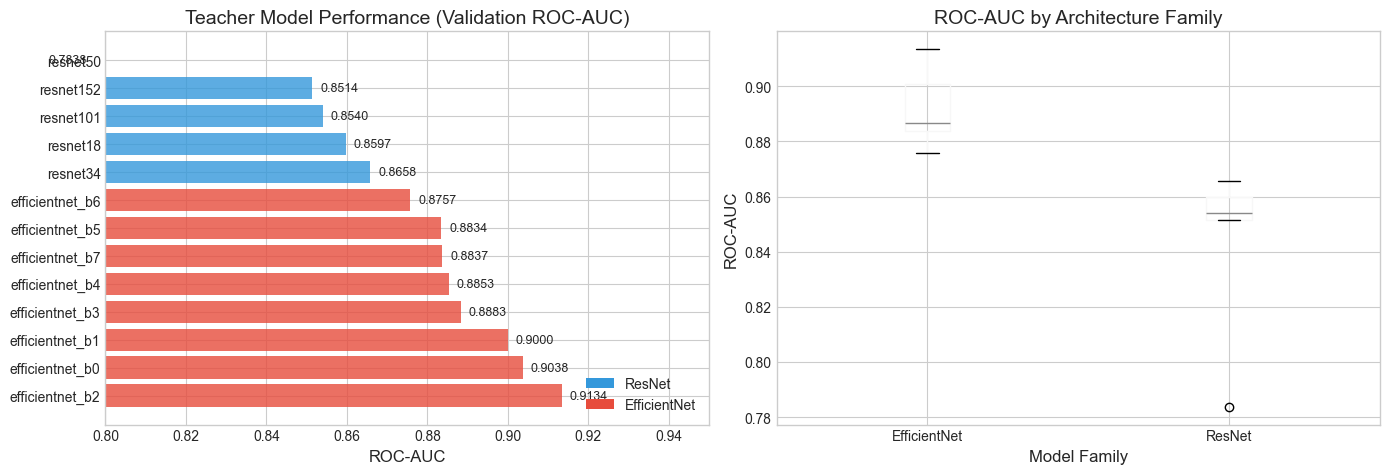


📈 Family Comparison:
   ResNet: Mean=0.8429, Std=0.0335
   EfficientNet: Mean=0.8917, Std=0.0127


In [ ]:
# Visualize teacher model comparison
if not df_teachers.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Add model family column
    df_viz = df_teachers.copy()
    df_viz["Family"] = df_viz["Model"].apply(
        lambda x: "ResNet" if "resnet" in x.lower() else "EfficientNet"
    )
    
    # Plot 1: ROC-AUC by model
    ax1 = axes[0]
    colors = ["#3498db" if "resnet" in m.lower() else "#e74c3c" for m in df_viz["Model"]]
    bars = ax1.barh(df_viz["Model"], df_viz["ROC-AUC"], color=colors, alpha=0.8)
    ax1.set_xlabel("ROC-AUC", fontsize=12)
    ax1.set_title("Teacher Model Performance (Validation ROC-AUC)", fontsize=14)
    ax1.set_xlim(0.80, 0.95)
    
    # Add value labels
    for bar, val in zip(bars, df_viz["ROC-AUC"]):
        ax1.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
                f"{val:.4f}", va='center', fontsize=9)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='ResNet'),
                      Patch(facecolor='#e74c3c', label='EfficientNet')]
    ax1.legend(handles=legend_elements, loc='lower right')
    
    # Plot 2: Family comparison boxplot
    ax2 = axes[1]
    df_viz.boxplot(column="ROC-AUC", by="Family", ax=ax2)
    ax2.set_title("ROC-AUC by Architecture Family", fontsize=14)
    ax2.set_xlabel("Model Family", fontsize=12)
    ax2.set_ylabel("ROC-AUC", fontsize=12)
    plt.suptitle("")  # Remove auto-generated title
    
    plt.tight_layout()
    plt.savefig(IMGS_DIR / "teacher_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Family statistics
    print("\n📈 Family Comparison:")
    for family in ["ResNet", "EfficientNet"]:
        family_data = df_viz[df_viz["Family"] == family]["ROC-AUC"]
        print(f"   {family}: Mean={family_data.mean():.4f}, Std={family_data.std():.4f}")

---

## 3. Knowledge Distilled Student Models

The student model (MobileNetV3-Small) was trained using knowledge distillation from the best teacher. Different temperature (T) and alpha (α) values were explored:

- **Temperature (T)**: Controls softness of teacher predictions
  - Higher T → softer probability distributions → more knowledge transfer
- **Alpha (α)**: Balance between hard labels and teacher's soft labels
  - α=0.5 → equal weight to both
  - α=0.9 → mostly rely on teacher's soft labels

### Student Architecture: MobileNetV3-Small
- **Parameters**: ~2.5M (vs 20-60M for teachers)
- **Target**: Mobile/edge deployment
- **Goal**: Maintain >90% of teacher performance with <10% of parameters

In [ ]:
# Load student checkpoint results
df_students = load_student_checkpoints(CHECKPOINTS_DIR)

if not df_students.empty:
    # Sort by ROC-AUC
    df_students = df_students.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
    
    display(Markdown("### Student Model Results (Validation Set)"))
    
    display_cols = ["Model", "Epoch", "ROC-AUC", "F1", "Accuracy"]
    available_cols = [c for c in display_cols if c in df_students.columns]
    
    display(df_students[available_cols].style.format({
        col: "{:.4f}" for col in available_cols if col not in ["Model", "Epoch"]
    }).background_gradient(subset=["ROC-AUC"], cmap="Greens"))
    
    # Best student
    best_student = df_students.iloc[0]
    print(f"\n🏆 Best Student Configuration: {best_student['Model']}")
    print(f"   ROC-AUC: {best_student['ROC-AUC']:.4f}")
    print(f"   F1 Score: {best_student['F1']:.4f}")
else:
    print("⚠️ No student checkpoints found. Run `make train-student` first.")

### Student Model Results (Validation Set)

,Model,Epoch,ROC-AUC,F1,Accuracy
0,MobileNetV3 (T2.0_alpha0.5),49,0.9028,0.5091,0.8384
1,MobileNetV3 (T1.0_alpha0.5),23,0.8989,0.4759,0.7979
2,MobileNetV3 (T1.0_alpha0.9),21,0.8781,0.4568,0.8245
3,MobileNetV3 (T2.0_alpha0.9),10,0.8713,0.4606,0.8178



🏆 Best Student Configuration: MobileNetV3 (T2.0_alpha0.5)
   ROC-AUC: 0.9028
   F1 Score: 0.5091


---

## 4. Overall Model Comparison

Compare all models across the pipeline: traditional ML → deep learning teachers → knowledge distilled student.

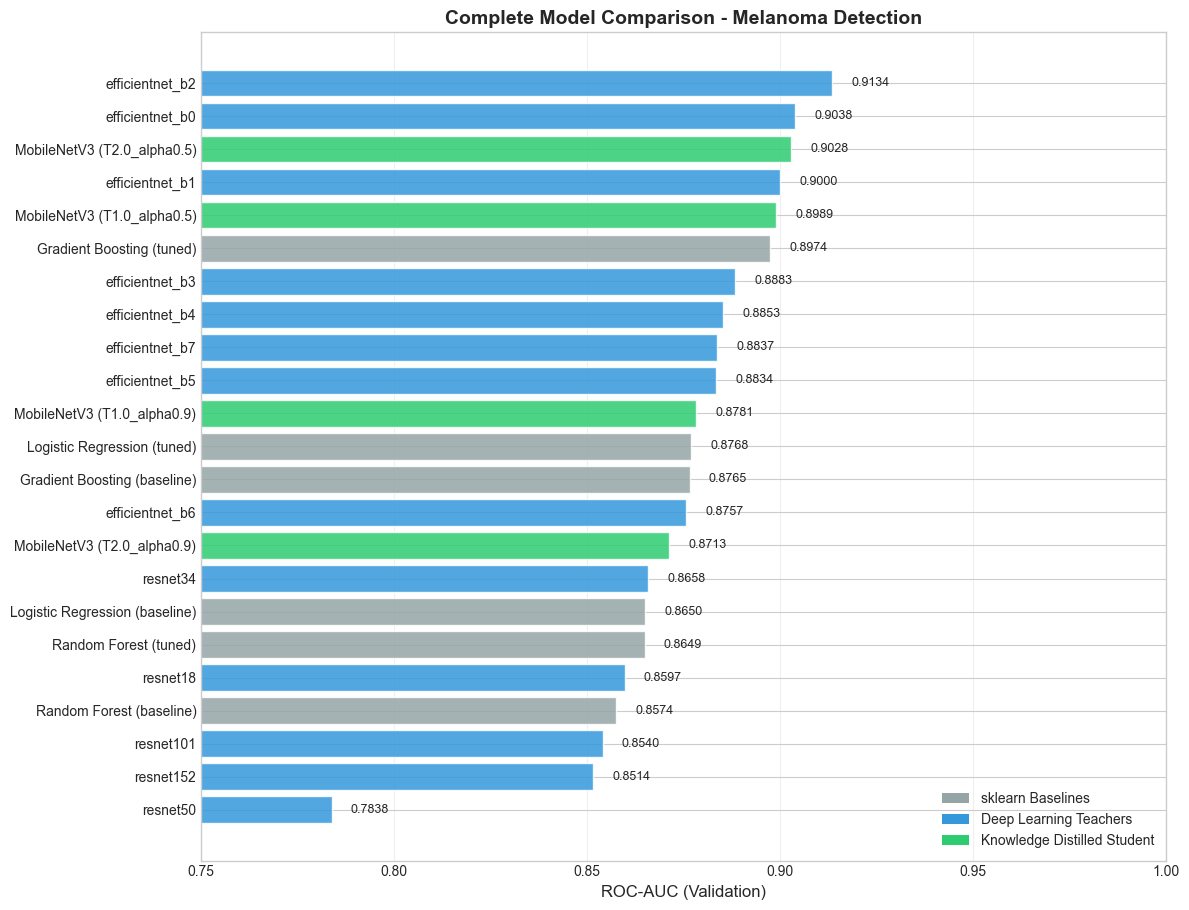

In [ ]:
# ============================================================================
# Comprehensive Model Comparison
# ============================================================================

# Combine all results
all_results = []

# Add sklearn results
if not df_sklearn.empty:
    for _, row in df_sklearn.iterrows():
        all_results.append({
            "Model": row["Model"],
            "Type": "sklearn",
            "ROC-AUC": row["ROC-AUC"],
            "Accuracy": row["Accuracy"],
        })

# Add teacher results
if not df_teachers.empty:
    for _, row in df_teachers.iterrows():
        all_results.append({
            "Model": row["Model"],
            "Type": "Teacher (DL)",
            "ROC-AUC": row["ROC-AUC"],
            "Accuracy": row.get("Accuracy", np.nan),
            "F1": row.get("F1", np.nan),
        })

# Add student results
if not df_students.empty:
    for _, row in df_students.iterrows():
        all_results.append({
            "Model": row["Model"],
            "Type": "Student (KD)",
            "ROC-AUC": row["ROC-AUC"],
            "Accuracy": row.get("Accuracy", np.nan),
            "F1": row.get("F1", np.nan),
        })

df_all = pd.DataFrame(all_results)

if not df_all.empty:
    # Sort by ROC-AUC
    df_all = df_all.sort_values("ROC-AUC", ascending=True).reset_index(drop=True)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, max(8, len(df_all) * 0.4)))
    
    # Color by type
    color_map = {
        "sklearn": "#95a5a6",
        "Teacher (DL)": "#3498db",
        "Student (KD)": "#2ecc71",
    }
    colors = [color_map.get(t, "#bdc3c7") for t in df_all["Type"]]
    
    bars = ax.barh(range(len(df_all)), df_all["ROC-AUC"], color=colors, alpha=0.85, edgecolor='white')
    ax.set_yticks(range(len(df_all)))
    ax.set_yticklabels(df_all["Model"], fontsize=10)
    ax.set_xlabel("ROC-AUC (Validation)", fontsize=12)
    ax.set_title("Complete Model Comparison - Melanoma Detection", fontsize=14, fontweight='bold')
    ax.set_xlim(0.75, 1.0)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, df_all["ROC-AUC"])):
        ax.text(val + 0.005, i, f"{val:.4f}", va='center', fontsize=9)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#95a5a6', label='sklearn Baselines'),
        Patch(facecolor='#3498db', label='Deep Learning Teachers'),
        Patch(facecolor='#2ecc71', label='Knowledge Distilled Student'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    # Add grid
    ax.xaxis.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig(IMGS_DIR / "complete_model_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No results available for comparison.")

In [ ]:
# Summary statistics by model type
if not df_all.empty:
    display(Markdown("### Summary by Model Type"))
    
    summary = df_all.groupby("Type").agg({
        "ROC-AUC": ["count", "mean", "std", "min", "max"]
    }).round(4)
    summary.columns = ["Count", "Mean ROC-AUC", "Std", "Min", "Max"]
    display(summary)
    
    # Best overall
    best_overall = df_all.loc[df_all["ROC-AUC"].idxmax()]
    
    print("\n" + "="*60)
    print("🏆 BEST OVERALL MODEL")
    print("="*60)
    print(f"   Model: {best_overall['Model']}")
    print(f"   Type: {best_overall['Type']}")
    print(f"   ROC-AUC: {best_overall['ROC-AUC']:.4f}")
    print("="*60)

### Summary by Model Type

,Count,Mean ROC-AUC,Std,Min,Max
Type,,,,,
Student (KD),4,0.8878,0.0154,0.8713,0.9028
Teacher (DL),13,0.8729,0.0328,0.7838,0.9134
sklearn,6,0.8730,0.0141,0.8574,0.8974



🏆 BEST OVERALL MODEL
   Model: efficientnet_b2
   Type: Teacher (DL)
   ROC-AUC: 0.9134


---

## 5. Knowledge Distillation Effectiveness

How well does the student retain the teacher's knowledge?

📊 KNOWLEDGE DISTILLATION EFFECTIVENESS

🎓 Best Teacher: efficientnet_b2
   ROC-AUC: 0.9134
   Approx. Parameters: ~25.0M

📱 Best Student: MobileNetV3 (T2.0_alpha0.5)
   ROC-AUC: 0.9028
   Approx. Parameters: ~2.5M

📈 Results:
   Knowledge Retention: 98.8%
   Model Compression: 10.0x smaller
   Performance Gap: 0.0107 AUC points


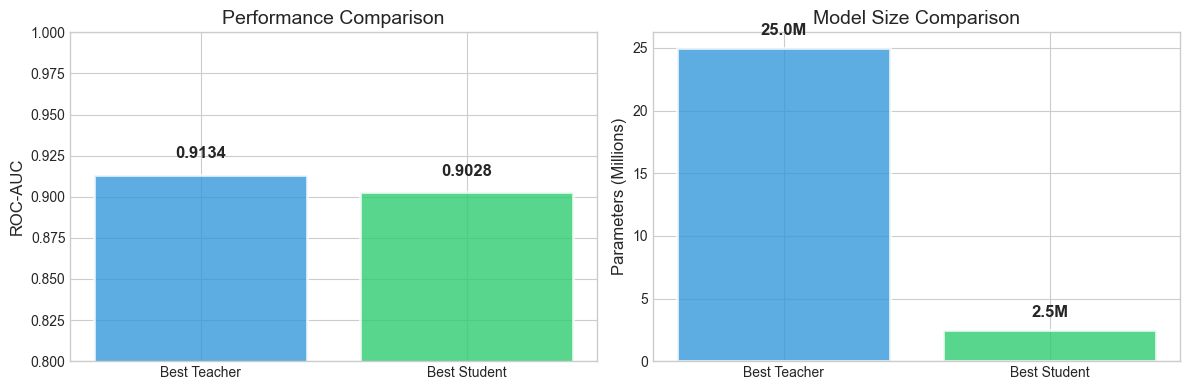

In [ ]:
# Knowledge Distillation Effectiveness Analysis
if not df_teachers.empty and not df_students.empty:
    best_teacher = df_teachers.loc[df_teachers["ROC-AUC"].idxmax()]
    best_student = df_students.loc[df_students["ROC-AUC"].idxmax()]
    
    teacher_auc = best_teacher["ROC-AUC"]
    student_auc = best_student["ROC-AUC"]
    retention = (student_auc / teacher_auc) * 100
    
    # Approximate model sizes (can be updated with actual values)
    teacher_params = 25.0  # Example: ResNet-50 ~25M params
    student_params = 2.5   # MobileNetV3-Small ~2.5M params
    compression = teacher_params / student_params
    
    print("="*60)
    print("📊 KNOWLEDGE DISTILLATION EFFECTIVENESS")
    print("="*60)
    print(f"\n🎓 Best Teacher: {best_teacher['Model']}")
    print(f"   ROC-AUC: {teacher_auc:.4f}")
    print(f"   Approx. Parameters: ~{teacher_params}M")
    
    print(f"\n📱 Best Student: {best_student['Model']}")
    print(f"   ROC-AUC: {student_auc:.4f}")
    print(f"   Approx. Parameters: ~{student_params}M")
    
    print(f"\n📈 Results:")
    print(f"   Knowledge Retention: {retention:.1f}%")
    print(f"   Model Compression: {compression:.1f}x smaller")
    print(f"   Performance Gap: {(teacher_auc - student_auc):.4f} AUC points")
    print("="*60)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Performance comparison
    ax1 = axes[0]
    models = ["Best Teacher", "Best Student"]
    aucs = [teacher_auc, student_auc]
    colors = ["#3498db", "#2ecc71"]
    bars = ax1.bar(models, aucs, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
    ax1.set_ylabel("ROC-AUC", fontsize=12)
    ax1.set_title("Performance Comparison", fontsize=14)
    ax1.set_ylim(0.8, 1.0)
    for bar, val in zip(bars, aucs):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.01, f"{val:.4f}", 
                ha='center', fontsize=12, fontweight='bold')
    
    # Size comparison
    ax2 = axes[1]
    params = [teacher_params, student_params]
    bars = ax2.bar(models, params, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
    ax2.set_ylabel("Parameters (Millions)", fontsize=12)
    ax2.set_title("Model Size Comparison", fontsize=14)
    for bar, val in zip(bars, params):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val}M", 
                ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(IMGS_DIR / "kd_effectiveness.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Need both teacher and student results for KD analysis.")

---

## 5b. Threshold Tuning Curves & 95% Sensitivity Analysis

For clinical deployment, melanoma screening requires high sensitivity (recall) to minimize missed diagnoses. 
We analyze the threshold-performance tradeoff and identify optimal operating points for 95% sensitivity.

In [ ]:
# ============================================================================
# Threshold Tuning Curves for Best Teacher and Student
# ============================================================================
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import torch
import sys
sys.path.insert(0, str(PROJECT_DIR))

from src.config import TeacherConfig, StudentConfig, DataConfig
from src.models.architectures import TeacherModel, StudentModel
from src.data.dataset import HAM10000Dataset, get_eval_transforms
from src.data.splits import load_or_create_splits

def load_model_and_get_predictions(model_type: str, checkpoint_path: Path, arch: str = None, device: str = 'cpu'):
    """Load a model and get predictions on validation set."""
    
    # Load model
    if model_type == "teacher":
        config = TeacherConfig(architecture=arch)
        model = TeacherModel(config)
    else:
        config = StudentConfig()
        model = StudentModel(config)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
    elif "state_dict" in checkpoint:
        model.load_state_dict(checkpoint["state_dict"])
    else:
        model.load_state_dict(checkpoint)
    
    model = model.to(device)
    model.eval()
    
    # Load validation data
    data_config = DataConfig()
    _, val_path, _ = load_or_create_splits()
    val_dataset = HAM10000Dataset(val_path, transform=get_eval_transforms(data_config))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Get predictions
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(targets.numpy())
    
    return np.concatenate(all_targets), np.concatenate(all_probs)


def plot_threshold_curves(y_true, y_prob, model_name: str, ax_roc, ax_pr, ax_thresh, color='blue'):
    """Plot ROC, PR, and threshold-metric curves for a model."""
    
    # ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
    roc_auc_val = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC={roc_auc_val:.4f})')
    
    # Mark 95% sensitivity point
    idx_95 = np.argmin(np.abs(tpr - 0.95))
    ax_roc.scatter([fpr[idx_95]], [tpr[idx_95]], color=color, s=100, marker='*', zorder=5, edgecolors='black')
    
    # PR curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc_val = auc(recall, precision)
    ax_pr.plot(recall, precision, color=color, lw=2, label=f'{model_name} (AUC={pr_auc_val:.4f})')
    
    # Mark 95% recall point
    idx_95_pr = np.argmin(np.abs(recall[:-1] - 0.95))
    ax_pr.scatter([recall[idx_95_pr]], [precision[idx_95_pr]], color=color, s=100, marker='*', zorder=5, edgecolors='black')
    
    # Threshold vs metrics curve
    thresholds_for_plot = np.linspace(0.01, 0.99, 50)
    sensitivities = []
    specificities = []
    ppvs = []
    
    for thresh in thresholds_for_plot:
        y_pred = (y_prob >= thresh).astype(int)
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tp = np.sum((y_pred == 1) & (y_true == 1))
        
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        sensitivities.append(sens)
        specificities.append(spec)
        ppvs.append(ppv)
    
    ax_thresh.plot(thresholds_for_plot, sensitivities, color=color, lw=2, linestyle='-', 
                   label=f'{model_name} Sensitivity')
    ax_thresh.plot(thresholds_for_plot, specificities, color=color, lw=2, linestyle='--', alpha=0.7)
    ax_thresh.plot(thresholds_for_plot, ppvs, color=color, lw=2, linestyle=':', alpha=0.7)
    
    # Find threshold for 95% sensitivity
    sens_array = np.array(sensitivities)
    valid_idx = np.where(sens_array >= 0.95)[0]
    if len(valid_idx) > 0:
        optimal_thresh = thresholds_for_plot[valid_idx[-1]]  # Highest threshold meeting 95% sens
        ax_thresh.axvline(x=optimal_thresh, color=color, linestyle='-.', alpha=0.5)
    
    return roc_auc_val, pr_auc_val


# Determine device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"🖥️  Using device: {device}")

# Find best EfficientNet teacher (B2 based on validation ROC-AUC)
best_efficientnet = "efficientnet_b2"
best_teacher_ckpt = CHECKPOINTS_DIR / f"teacher_{best_efficientnet}_focal_best.pth"

# Find best student
best_student_ckpt = None
best_student_config = None
best_student_auc = 0

for meta_file in CHECKPOINTS_DIR.glob("student_*_meta.json"):
    data = json.loads(meta_file.read_text())
    auc_val = data.get("metrics", {}).get("roc_auc", 0)
    if auc_val > best_student_auc:
        best_student_auc = auc_val
        best_student_config = meta_file.stem.replace("_best_meta", "")
        best_student_ckpt = CHECKPOINTS_DIR / f"{best_student_config}_best.pth"

print(f"📊 Best Teacher: {best_efficientnet}")
print(f"📊 Best Student: {best_student_config}")

# Load models and get predictions
print("\n⏳ Loading models and generating predictions...")
try:
    teacher_true, teacher_prob = load_model_and_get_predictions(
        "teacher", best_teacher_ckpt, best_efficientnet, device
    )
    student_true, student_prob = load_model_and_get_predictions(
        "student", best_student_ckpt, device=device
    )
    print("✅ Predictions generated successfully")
except Exception as e:
    print(f"❌ Error loading models: {e}")
    teacher_true, teacher_prob = None, None
    student_true, student_prob = None, None

🖥️  Using device: mps
📊 Best Teacher: efficientnet_b2
📊 Best Student: student_T2.0_alpha0.5

⏳ Loading models and generating predictions...
✅ Predictions generated successfully


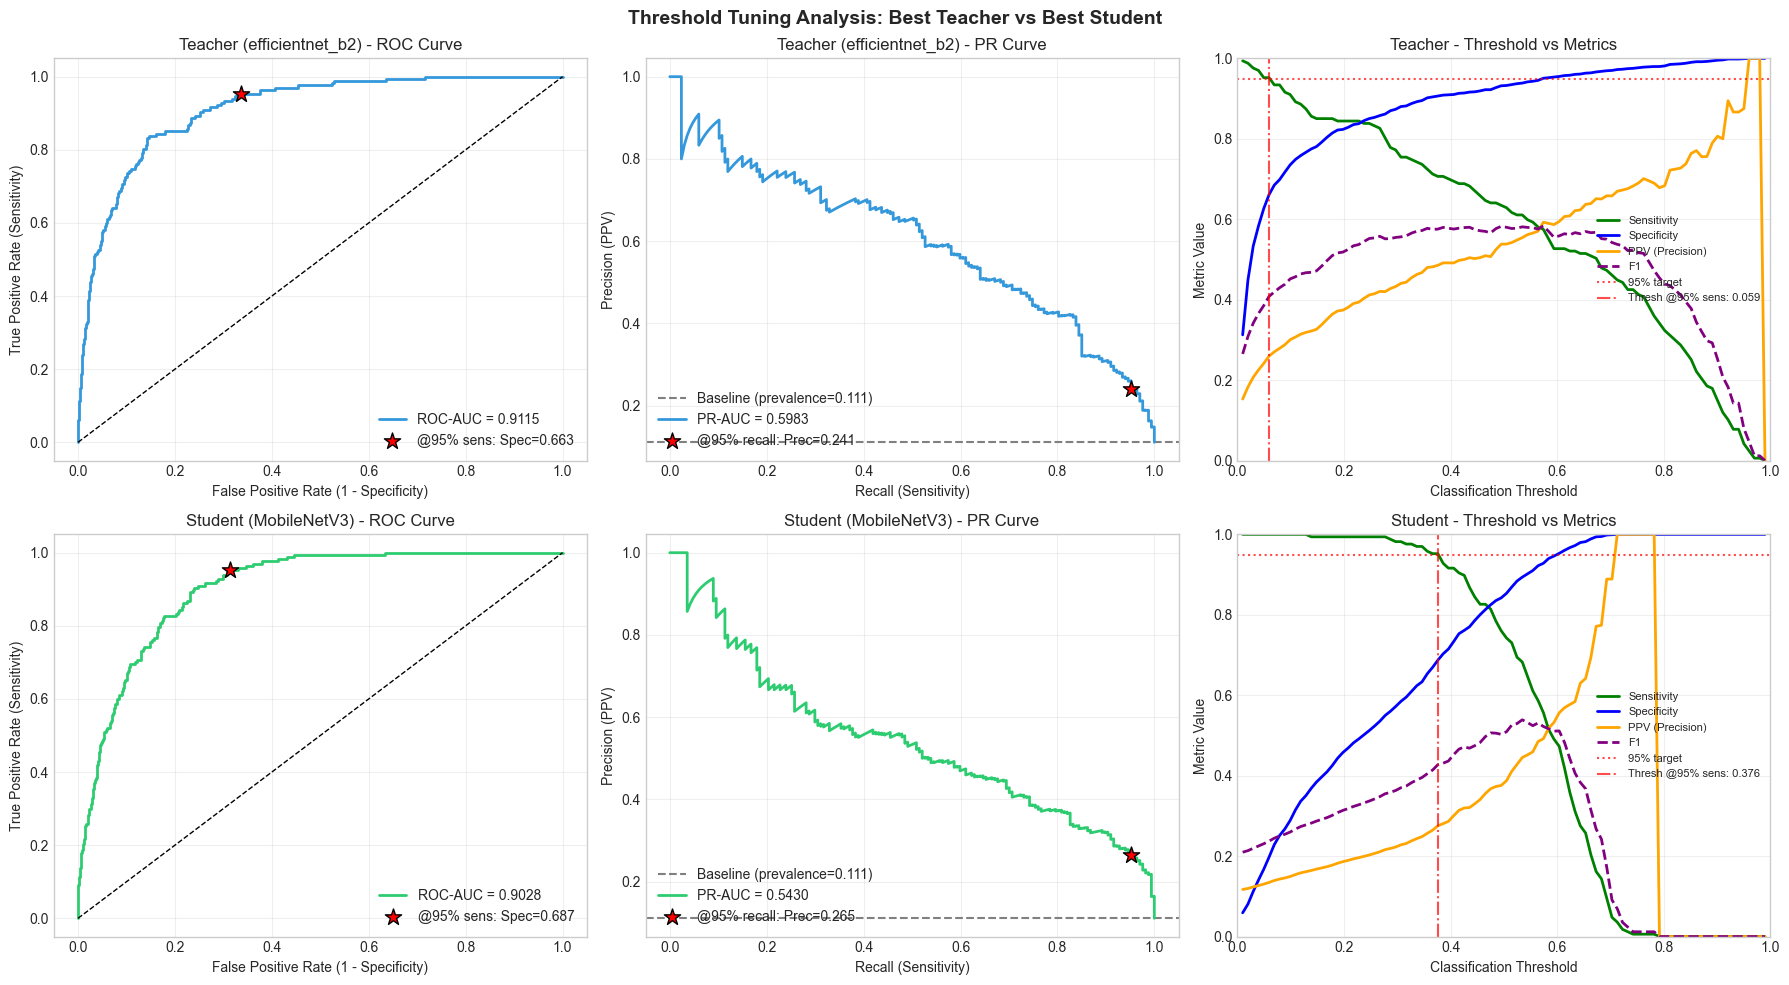


📊 THRESHOLD TUNING SUMMARY @ 95% SENSITIVITY
Model                             Threshold  Specificity          PPV
----------------------------------------------------------------------
Teacher (EfficientNet-B2)             0.059        0.661        0.260
Student (MobileNetV3)                 0.376        0.687        0.276


In [ ]:
# ============================================================================
# Visualize Threshold Tuning Curves
# ============================================================================

if teacher_prob is not None and student_prob is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Colors
    teacher_color = '#3498db'
    student_color = '#2ecc71'
    
    # Row 1: Teacher curves
    ax_roc_t, ax_pr_t, ax_thresh_t = axes[0]
    
    # ROC Curve - Teacher
    fpr_t, tpr_t, _ = roc_curve(teacher_true, teacher_prob)
    roc_auc_t = auc(fpr_t, tpr_t)
    ax_roc_t.plot(fpr_t, tpr_t, color=teacher_color, lw=2, label=f'ROC-AUC = {roc_auc_t:.4f}')
    ax_roc_t.plot([0, 1], [0, 1], 'k--', lw=1)
    
    # Mark 95% sensitivity
    idx_95_t = np.argmin(np.abs(tpr_t - 0.95))
    ax_roc_t.scatter([fpr_t[idx_95_t]], [tpr_t[idx_95_t]], color='red', s=150, marker='*', zorder=5, 
                     edgecolors='black', label=f'@95% sens: Spec={1-fpr_t[idx_95_t]:.3f}')
    ax_roc_t.set_xlabel('False Positive Rate (1 - Specificity)')
    ax_roc_t.set_ylabel('True Positive Rate (Sensitivity)')
    ax_roc_t.set_title(f'Teacher ({best_efficientnet}) - ROC Curve', fontsize=12)
    ax_roc_t.legend(loc='lower right')
    ax_roc_t.grid(True, alpha=0.3)
    
    # PR Curve - Teacher
    prec_t, rec_t, _ = precision_recall_curve(teacher_true, teacher_prob)
    pr_auc_t = auc(rec_t, prec_t)
    prevalence = teacher_true.mean()
    ax_pr_t.axhline(y=prevalence, color='gray', linestyle='--', label=f'Baseline (prevalence={prevalence:.3f})')
    ax_pr_t.plot(rec_t, prec_t, color=teacher_color, lw=2, label=f'PR-AUC = {pr_auc_t:.4f}')
    
    # Mark 95% recall point
    idx_95_pr_t = np.argmin(np.abs(rec_t[:-1] - 0.95))
    ax_pr_t.scatter([rec_t[idx_95_pr_t]], [prec_t[idx_95_pr_t]], color='red', s=150, marker='*', zorder=5,
                    edgecolors='black', label=f'@95% recall: Prec={prec_t[idx_95_pr_t]:.3f}')
    ax_pr_t.set_xlabel('Recall (Sensitivity)')
    ax_pr_t.set_ylabel('Precision (PPV)')
    ax_pr_t.set_title(f'Teacher ({best_efficientnet}) - PR Curve', fontsize=12)
    ax_pr_t.legend(loc='lower left')
    ax_pr_t.grid(True, alpha=0.3)
    
    # Threshold curve - Teacher
    thresholds = np.linspace(0.01, 0.99, 100)
    metrics_t = {'sensitivity': [], 'specificity': [], 'ppv': [], 'f1': []}
    
    for thresh in thresholds:
        y_pred = (teacher_prob >= thresh).astype(int)
        tn = np.sum((y_pred == 0) & (teacher_true == 0))
        fp = np.sum((y_pred == 1) & (teacher_true == 0))
        fn = np.sum((y_pred == 0) & (teacher_true == 1))
        tp = np.sum((y_pred == 1) & (teacher_true == 1))
        
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * ppv * sens / (ppv + sens) if (ppv + sens) > 0 else 0
        
        metrics_t['sensitivity'].append(sens)
        metrics_t['specificity'].append(spec)
        metrics_t['ppv'].append(ppv)
        metrics_t['f1'].append(f1)
    
    ax_thresh_t.plot(thresholds, metrics_t['sensitivity'], color='green', lw=2, label='Sensitivity')
    ax_thresh_t.plot(thresholds, metrics_t['specificity'], color='blue', lw=2, label='Specificity')
    ax_thresh_t.plot(thresholds, metrics_t['ppv'], color='orange', lw=2, label='PPV (Precision)')
    ax_thresh_t.plot(thresholds, metrics_t['f1'], color='purple', lw=2, linestyle='--', label='F1')
    ax_thresh_t.axhline(y=0.95, color='red', linestyle=':', alpha=0.7, label='95% target')
    
    # Find threshold for 95% sensitivity
    sens_arr = np.array(metrics_t['sensitivity'])
    valid_idx = np.where(sens_arr >= 0.95)[0]
    if len(valid_idx) > 0:
        opt_thresh_t = thresholds[valid_idx[-1]]
        ax_thresh_t.axvline(x=opt_thresh_t, color='red', linestyle='-.', alpha=0.7, 
                           label=f'Thresh @95% sens: {opt_thresh_t:.3f}')
    
    ax_thresh_t.set_xlabel('Classification Threshold')
    ax_thresh_t.set_ylabel('Metric Value')
    ax_thresh_t.set_title('Teacher - Threshold vs Metrics', fontsize=12)
    ax_thresh_t.legend(loc='center right', fontsize=8)
    ax_thresh_t.grid(True, alpha=0.3)
    ax_thresh_t.set_xlim([0, 1])
    ax_thresh_t.set_ylim([0, 1])
    
    # Row 2: Student curves
    ax_roc_s, ax_pr_s, ax_thresh_s = axes[1]
    
    # ROC Curve - Student
    fpr_s, tpr_s, _ = roc_curve(student_true, student_prob)
    roc_auc_s = auc(fpr_s, tpr_s)
    ax_roc_s.plot(fpr_s, tpr_s, color=student_color, lw=2, label=f'ROC-AUC = {roc_auc_s:.4f}')
    ax_roc_s.plot([0, 1], [0, 1], 'k--', lw=1)
    
    idx_95_s = np.argmin(np.abs(tpr_s - 0.95))
    ax_roc_s.scatter([fpr_s[idx_95_s]], [tpr_s[idx_95_s]], color='red', s=150, marker='*', zorder=5,
                     edgecolors='black', label=f'@95% sens: Spec={1-fpr_s[idx_95_s]:.3f}')
    ax_roc_s.set_xlabel('False Positive Rate (1 - Specificity)')
    ax_roc_s.set_ylabel('True Positive Rate (Sensitivity)')
    ax_roc_s.set_title(f'Student (MobileNetV3) - ROC Curve', fontsize=12)
    ax_roc_s.legend(loc='lower right')
    ax_roc_s.grid(True, alpha=0.3)
    
    # PR Curve - Student
    prec_s, rec_s, _ = precision_recall_curve(student_true, student_prob)
    pr_auc_s = auc(rec_s, prec_s)
    ax_pr_s.axhline(y=prevalence, color='gray', linestyle='--', label=f'Baseline (prevalence={prevalence:.3f})')
    ax_pr_s.plot(rec_s, prec_s, color=student_color, lw=2, label=f'PR-AUC = {pr_auc_s:.4f}')
    
    idx_95_pr_s = np.argmin(np.abs(rec_s[:-1] - 0.95))
    ax_pr_s.scatter([rec_s[idx_95_pr_s]], [prec_s[idx_95_pr_s]], color='red', s=150, marker='*', zorder=5,
                    edgecolors='black', label=f'@95% recall: Prec={prec_s[idx_95_pr_s]:.3f}')
    ax_pr_s.set_xlabel('Recall (Sensitivity)')
    ax_pr_s.set_ylabel('Precision (PPV)')
    ax_pr_s.set_title('Student (MobileNetV3) - PR Curve', fontsize=12)
    ax_pr_s.legend(loc='lower left')
    ax_pr_s.grid(True, alpha=0.3)
    
    # Threshold curve - Student
    metrics_s = {'sensitivity': [], 'specificity': [], 'ppv': [], 'f1': []}
    
    for thresh in thresholds:
        y_pred = (student_prob >= thresh).astype(int)
        tn = np.sum((y_pred == 0) & (student_true == 0))
        fp = np.sum((y_pred == 1) & (student_true == 0))
        fn = np.sum((y_pred == 0) & (student_true == 1))
        tp = np.sum((y_pred == 1) & (student_true == 1))
        
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * ppv * sens / (ppv + sens) if (ppv + sens) > 0 else 0
        
        metrics_s['sensitivity'].append(sens)
        metrics_s['specificity'].append(spec)
        metrics_s['ppv'].append(ppv)
        metrics_s['f1'].append(f1)
    
    ax_thresh_s.plot(thresholds, metrics_s['sensitivity'], color='green', lw=2, label='Sensitivity')
    ax_thresh_s.plot(thresholds, metrics_s['specificity'], color='blue', lw=2, label='Specificity')
    ax_thresh_s.plot(thresholds, metrics_s['ppv'], color='orange', lw=2, label='PPV (Precision)')
    ax_thresh_s.plot(thresholds, metrics_s['f1'], color='purple', lw=2, linestyle='--', label='F1')
    ax_thresh_s.axhline(y=0.95, color='red', linestyle=':', alpha=0.7, label='95% target')
    
    sens_arr_s = np.array(metrics_s['sensitivity'])
    valid_idx_s = np.where(sens_arr_s >= 0.95)[0]
    if len(valid_idx_s) > 0:
        opt_thresh_s = thresholds[valid_idx_s[-1]]
        ax_thresh_s.axvline(x=opt_thresh_s, color='red', linestyle='-.', alpha=0.7,
                           label=f'Thresh @95% sens: {opt_thresh_s:.3f}')
    
    ax_thresh_s.set_xlabel('Classification Threshold')
    ax_thresh_s.set_ylabel('Metric Value')
    ax_thresh_s.set_title('Student - Threshold vs Metrics', fontsize=12)
    ax_thresh_s.legend(loc='center right', fontsize=8)
    ax_thresh_s.grid(True, alpha=0.3)
    ax_thresh_s.set_xlim([0, 1])
    ax_thresh_s.set_ylim([0, 1])
    
    plt.suptitle('Threshold Tuning Analysis: Best Teacher vs Best Student', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(IMGS_DIR / "threshold_tuning_curves.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary table
    print("\n" + "="*70)
    print("📊 THRESHOLD TUNING SUMMARY @ 95% SENSITIVITY")
    print("="*70)
    print(f"{'Model':<30} {'Threshold':>12} {'Specificity':>12} {'PPV':>12}")
    print("-"*70)
    
    if len(valid_idx) > 0:
        spec_at_95_t = metrics_t['specificity'][valid_idx[-1]]
        ppv_at_95_t = metrics_t['ppv'][valid_idx[-1]]
        print(f"{'Teacher (EfficientNet-B2)':<30} {opt_thresh_t:>12.3f} {spec_at_95_t:>12.3f} {ppv_at_95_t:>12.3f}")
    
    if len(valid_idx_s) > 0:
        spec_at_95_s = metrics_s['specificity'][valid_idx_s[-1]]
        ppv_at_95_s = metrics_s['ppv'][valid_idx_s[-1]]
        print(f"{'Student (MobileNetV3)':<30} {opt_thresh_s:>12.3f} {spec_at_95_s:>12.3f} {ppv_at_95_s:>12.3f}")
    print("="*70)
else:
    print("⚠️ Could not generate threshold curves - model predictions not available")

---

## 6. Inference Latency Benchmarks

Measuring inference speed is critical for deployment decisions. We benchmark:
- **CPU inference**: For server/edge deployment without GPU
- **GPU inference** (if available): For high-throughput scenarios
- **Model loading time**: One-time cost at startup
- **Throughput**: Images processed per second

In [ ]:
# ============================================================================
# Inference Latency Benchmarks
# ============================================================================
import time
import torch
import sys
sys.path.insert(0, str(PROJECT_DIR))

from src.models.architectures import TeacherModel, StudentModel

def benchmark_model(model, input_size=(1, 3, 224, 224), num_warmup=10, num_runs=100, device='cpu'):
    """
    Benchmark model inference latency.
    
    Returns dict with timing statistics.
    """
    model = model.to(device)
    model.eval()
    
    # Create dummy input
    dummy_input = torch.randn(*input_size).to(device)
    
    # Warmup runs (important for GPU)
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(dummy_input)
    
    # Synchronize if GPU
    if device != 'cpu' and torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Timed runs
    latencies = []
    with torch.no_grad():
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = model(dummy_input)
            if device != 'cpu' and torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.perf_counter()
            latencies.append((end - start) * 1000)  # Convert to ms
    
    latencies = np.array(latencies)
    
    return {
        'mean_ms': latencies.mean(),
        'std_ms': latencies.std(),
        'min_ms': latencies.min(),
        'max_ms': latencies.max(),
        'p50_ms': np.percentile(latencies, 50),
        'p95_ms': np.percentile(latencies, 95),
        'p99_ms': np.percentile(latencies, 99),
        'throughput_fps': 1000 / latencies.mean(),
    }


def get_model_size_mb(model):
    """Calculate model size in MB."""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 * 1024)


def count_parameters(model):
    """Count trainable and total parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'total': total, 'trainable': trainable}


print("✅ Benchmark functions defined")

✅ Benchmark functions defined


In [ ]:
# ============================================================================
# Run Latency Benchmarks on Available Models
# ============================================================================
from src.config import TeacherConfig, StudentConfig

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"🖥️  Benchmarking on device: {device}")

# Models to benchmark
benchmark_configs = [
    # Teachers - sample of different sizes
    ("ResNet-18", "resnet18"),
    ("ResNet-34", "resnet34"),
    ("ResNet-50", "resnet50"),
    ("EfficientNet-B0", "efficientnet_b0"),
    ("EfficientNet-B2", "efficientnet_b2"),
    ("EfficientNet-B4", "efficientnet_b4"),
    # Student
    ("MobileNetV3-Small (Student)", "student"),
]

latency_results = []

print("\n⏱️  Running inference benchmarks (this may take a minute)...\n")

for name, arch in benchmark_configs:
    try:
        # Create model with proper config
        if arch == "student":
            config = StudentConfig(pretrained=False)
            model = StudentModel(config=config)
        else:
            config = TeacherConfig(architecture=arch, pretrained=False)
            model = TeacherModel(config=config)
        
        # Get model info
        params = count_parameters(model)
        size_mb = get_model_size_mb(model)
        
        # Benchmark on CPU first
        cpu_stats = benchmark_model(model, num_warmup=5, num_runs=50, device='cpu')
        
        # Benchmark on GPU/MPS if available
        if device != 'cpu':
            try:
                gpu_stats = benchmark_model(model, num_warmup=10, num_runs=100, device=device)
            except Exception as e:
                print(f"  (GPU benchmark failed for {name}: {e})")
                gpu_stats = None
        else:
            gpu_stats = None
        
        result = {
            'Model': name,
            'Architecture': arch,
            'Parameters (M)': params['total'] / 1e6,
            'Size (MB)': size_mb,
            'CPU Latency (ms)': cpu_stats['mean_ms'],
            'CPU Std (ms)': cpu_stats['std_ms'],
            'CPU Throughput (FPS)': cpu_stats['throughput_fps'],
        }
        
        if gpu_stats:
            result['GPU Latency (ms)'] = gpu_stats['mean_ms']
            result['GPU Throughput (FPS)'] = gpu_stats['throughput_fps']
        
        latency_results.append(result)
        print(f"✓ {name}: CPU={cpu_stats['mean_ms']:.2f}ms" + 
              (f", GPU={gpu_stats['mean_ms']:.2f}ms" if gpu_stats else ""))
        
        # Clean up
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"✗ {name}: Failed - {e}")

df_latency = pd.DataFrame(latency_results)
print(f"\n✅ Benchmarked {len(latency_results)} models")

🖥️  Benchmarking on device: mps

⏱️  Running inference benchmarks (this may take a minute)...

✓ ResNet-18: CPU=6.97ms, GPU=1.98ms
✓ ResNet-34: CPU=14.04ms, GPU=3.37ms
✓ ResNet-50: CPU=16.48ms, GPU=5.13ms
✓ EfficientNet-B0: CPU=271.86ms, GPU=6.45ms
✓ EfficientNet-B2: CPU=381.61ms, GPU=9.37ms
✓ EfficientNet-B4: CPU=772.07ms, GPU=12.87ms
✓ MobileNetV3-Small (Student): CPU=95.40ms, GPU=3.74ms

✅ Benchmarked 7 models


### Inference Latency Results

,Model,Parameters (M),Size (MB),CPU Latency (ms),CPU Throughput (FPS),GPU Latency (ms),GPU Throughput (FPS)
0,ResNet-18,11.18,42.7,6.97,143.4,1.98,505.4
1,ResNet-34,21.29,81.3,14.04,71.2,3.37,296.9
2,ResNet-50,23.51,89.9,16.48,60.7,5.13,195.1
3,EfficientNet-B0,4.01,15.5,271.86,3.7,6.45,155.1
4,EfficientNet-B2,7.70,29.6,381.61,2.6,9.37,106.8
5,EfficientNet-B4,17.55,67.4,772.07,1.3,12.87,77.7
6,MobileNetV3-Small (Student),1.52,5.8,95.40,10.5,3.74,267.3


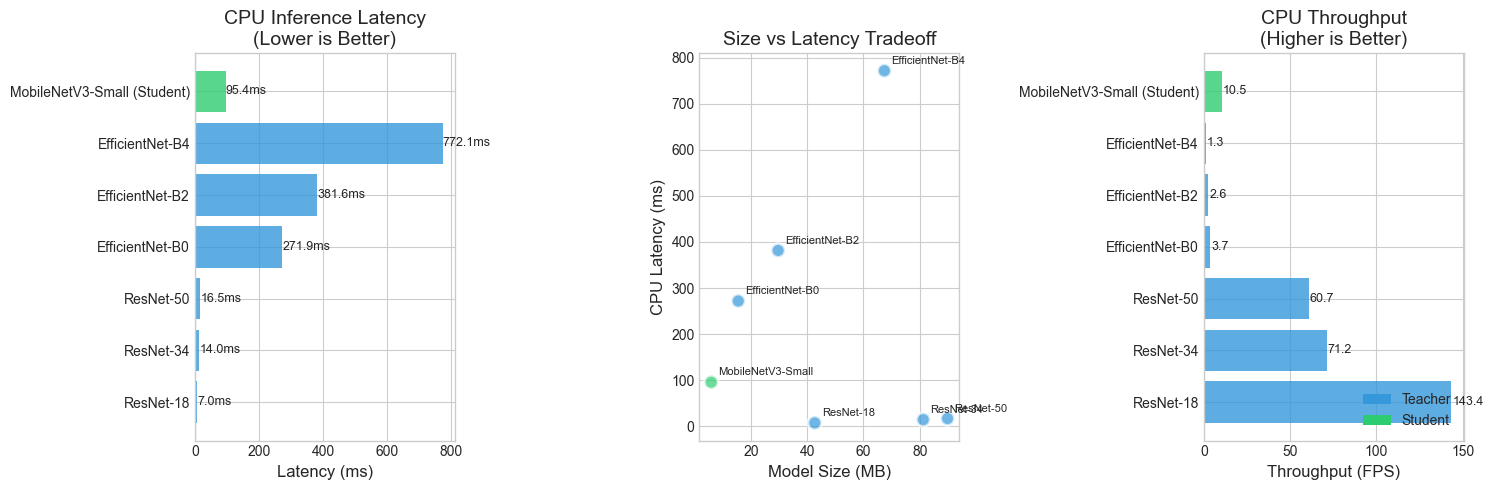


⚡ LATENCY SUMMARY
📱 Student Model (MobileNetV3-Small):
   CPU Latency: 95.40 ms
   CPU Throughput: 10.5 FPS

🎓 Average Teacher Latency: 243.84 ms
📈 Student Speedup: 2.6x faster than average teacher


In [ ]:
# ============================================================================
# Visualize Latency Results
# ============================================================================

if not df_latency.empty:
    display(Markdown("### Inference Latency Results"))
    
    # Format and display table
    display_cols = ['Model', 'Parameters (M)', 'Size (MB)', 'CPU Latency (ms)', 'CPU Throughput (FPS)']
    if 'GPU Latency (ms)' in df_latency.columns:
        display_cols.extend(['GPU Latency (ms)', 'GPU Throughput (FPS)'])
    
    display(df_latency[display_cols].style.format({
        'Parameters (M)': '{:.2f}',
        'Size (MB)': '{:.1f}',
        'CPU Latency (ms)': '{:.2f}',
        'CPU Throughput (FPS)': '{:.1f}',
        'GPU Latency (ms)': '{:.2f}',
        'GPU Throughput (FPS)': '{:.1f}',
    }).background_gradient(subset=['CPU Latency (ms)'], cmap='Reds_r'))
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: CPU Latency comparison
    ax1 = axes[0]
    colors = ['#2ecc71' if 'Student' in m else '#3498db' for m in df_latency['Model']]
    bars = ax1.barh(df_latency['Model'], df_latency['CPU Latency (ms)'], color=colors, alpha=0.8)
    ax1.set_xlabel('Latency (ms)', fontsize=12)
    ax1.set_title('CPU Inference Latency\n(Lower is Better)', fontsize=14)
    for bar, val in zip(bars, df_latency['CPU Latency (ms)']):
        ax1.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}ms', va='center', fontsize=9)
    
    # Plot 2: Model Size vs Latency
    ax2 = axes[1]
    colors = ['#2ecc71' if 'Student' in m else '#3498db' for m in df_latency['Model']]
    ax2.scatter(df_latency['Size (MB)'], df_latency['CPU Latency (ms)'], 
                c=colors, s=100, alpha=0.7, edgecolors='white', linewidth=2)
    for i, row in df_latency.iterrows():
        ax2.annotate(row['Model'].split()[0], (row['Size (MB)'], row['CPU Latency (ms)']),
                    textcoords="offset points", xytext=(5, 5), fontsize=8)
    ax2.set_xlabel('Model Size (MB)', fontsize=12)
    ax2.set_ylabel('CPU Latency (ms)', fontsize=12)
    ax2.set_title('Size vs Latency Tradeoff', fontsize=14)
    
    # Plot 3: Throughput comparison
    ax3 = axes[2]
    colors = ['#2ecc71' if 'Student' in m else '#3498db' for m in df_latency['Model']]
    bars = ax3.barh(df_latency['Model'], df_latency['CPU Throughput (FPS)'], color=colors, alpha=0.8)
    ax3.set_xlabel('Throughput (FPS)', fontsize=12)
    ax3.set_title('CPU Throughput\n(Higher is Better)', fontsize=14)
    for bar, val in zip(bars, df_latency['CPU Throughput (FPS)']):
        ax3.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}', va='center', fontsize=9)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Teacher'),
                      Patch(facecolor='#2ecc71', label='Student')]
    ax3.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig(IMGS_DIR / "latency_benchmarks.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary
    student_row = df_latency[df_latency['Model'].str.contains('Student')]
    if not student_row.empty:
        student_latency = student_row['CPU Latency (ms)'].values[0]
        student_fps = student_row['CPU Throughput (FPS)'].values[0]
        
        # Compare to average teacher
        teacher_rows = df_latency[~df_latency['Model'].str.contains('Student')]
        avg_teacher_latency = teacher_rows['CPU Latency (ms)'].mean()
        
        speedup = avg_teacher_latency / student_latency
        
        print("\n" + "="*60)
        print("⚡ LATENCY SUMMARY")
        print("="*60)
        print(f"📱 Student Model (MobileNetV3-Small):")
        print(f"   CPU Latency: {student_latency:.2f} ms")
        print(f"   CPU Throughput: {student_fps:.1f} FPS")
        print(f"\n🎓 Average Teacher Latency: {avg_teacher_latency:.2f} ms")
        print(f"📈 Student Speedup: {speedup:.1f}x faster than average teacher")
        print("="*60)

In [ ]:
# Save latency benchmark results
if not df_latency.empty:
    latency_output_path = ARTIFACTS_DIR / "latency_benchmarks.csv"
    df_latency.to_csv(latency_output_path, index=False)
    print(f"✅ Latency results saved to: {latency_output_path}")
    
    # Display key insights
    display(Markdown("### Key Latency Insights"))
    
    # Find fastest and slowest
    fastest = df_latency.loc[df_latency['CPU Latency (ms)'].idxmin()]
    slowest = df_latency.loc[df_latency['CPU Latency (ms)'].idxmax()]
    
    print(f"🚀 Fastest Model: {fastest['Model']} ({fastest['CPU Latency (ms)']:.2f} ms)")
    print(f"🐢 Slowest Model: {slowest['Model']} ({slowest['CPU Latency (ms)']:.2f} ms)")
    print(f"⚡ Speed Difference: {slowest['CPU Latency (ms)'] / fastest['CPU Latency (ms)']:.1f}x")
    
    # Mobile-ready check (< 100ms is generally acceptable)
    mobile_ready = df_latency[df_latency['CPU Latency (ms)'] < 100]
    print(f"\n📱 Models suitable for mobile (< 100ms CPU): {len(mobile_ready)}")
    for _, row in mobile_ready.iterrows():
        print(f"   - {row['Model']}: {row['CPU Latency (ms)']:.1f}ms")

✅ Latency results saved to: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/artifacts/tbls/01_baselines/latency_benchmarks.csv


### Key Latency Insights

🚀 Fastest Model: ResNet-18 (6.97 ms)
🐢 Slowest Model: EfficientNet-B4 (772.07 ms)
⚡ Speed Difference: 110.7x

📱 Models suitable for mobile (< 100ms CPU): 4
   - ResNet-18: 7.0ms
   - ResNet-34: 14.0ms
   - ResNet-50: 16.5ms
   - MobileNetV3-Small (Student): 95.4ms


---

## 7. Holdout Set Evaluation (Final Test)

Evaluate the best teacher (EfficientNet-B2) and best student models on the **holdout test set** - 
data that was never seen during training or hyperparameter tuning. This provides an unbiased estimate 
of model generalization performance.

### Important Notes:
- The holdout set represents 15% of the original data
- No model selection or tuning decisions were made using this data
- These are the final reported metrics for the project

In [ ]:
# ============================================================================
# Holdout Set Evaluation
# ============================================================================
import torch
import sys
sys.path.insert(0, str(PROJECT_DIR))

from src.config import TeacherConfig, StudentConfig, DataConfig, PROCESSED_DIR
from src.models.architectures import TeacherModel, StudentModel
from src.data.dataset import HAM10000Dataset, get_eval_transforms
from src.evaluation.metrics import evaluate_model, compute_deployment_metrics

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"🖥️  Using device: {device}")

# Load holdout data
data_config = DataConfig()
holdout_path = PROCESSED_DIR / "holdout_data.csv"

if holdout_path.exists():
    holdout_dataset = HAM10000Dataset(holdout_path, transform=get_eval_transforms(data_config))
    holdout_loader = torch.utils.data.DataLoader(holdout_dataset, batch_size=32, shuffle=False, num_workers=0)
    print(f"📊 Holdout set size: {len(holdout_dataset)} samples")
    
    # Check class balance
    holdout_df = pd.read_csv(holdout_path)
    print(f"   Positive (melanoma): {holdout_df['target'].sum()} ({holdout_df['target'].mean()*100:.1f}%)")
    print(f"   Negative (benign): {len(holdout_df) - holdout_df['target'].sum()} ({(1-holdout_df['target'].mean())*100:.1f}%)")
else:
    print(f"❌ Holdout data not found at {holdout_path}")
    holdout_loader = None

🖥️  Using device: mps
📊 Holdout set size: 1513 samples
   Positive (melanoma): 172 (11.4%)
   Negative (benign): 1341 (88.6%)


In [ ]:
# ============================================================================
# Evaluate Best Teacher on Holdout
# ============================================================================

holdout_results = {}

if holdout_loader is not None:
    # Best EfficientNet teacher
    best_teacher_arch = "efficientnet_b2"
    best_teacher_ckpt = CHECKPOINTS_DIR / f"teacher_{best_teacher_arch}_focal_best.pth"
    
    if best_teacher_ckpt.exists():
        print(f"\n🎓 Evaluating Best Teacher: {best_teacher_arch}")
        
        # Load teacher
        teacher_config = TeacherConfig(architecture=best_teacher_arch)
        teacher = TeacherModel(teacher_config)
        
        checkpoint = torch.load(best_teacher_ckpt, map_location=device)
        if "model_state_dict" in checkpoint:
            teacher.load_state_dict(checkpoint["model_state_dict"])
        elif "state_dict" in checkpoint:
            teacher.load_state_dict(checkpoint["state_dict"])
        else:
            teacher.load_state_dict(checkpoint)
        
        teacher = teacher.to(device)
        teacher.eval()
        
        # Evaluate
        teacher_metrics = evaluate_model(teacher, holdout_loader, device, target_sensitivity=0.95)
        teacher_deployment = compute_deployment_metrics(teacher, device=device)
        
        holdout_results['Teacher (EfficientNet-B2)'] = {
            'metrics': teacher_metrics,
            'deployment': teacher_deployment,
        }
        
        print(f"   ✅ ROC-AUC: {teacher_metrics.roc_auc:.4f}")
        print(f"   ✅ PR-AUC: {teacher_metrics.pr_auc:.4f}")
        print(f"   ✅ F1: {teacher_metrics.f1:.4f}")
        print(f"   ✅ Sensitivity: {teacher_metrics.recall:.4f}")
        print(f"   ✅ Specificity: {teacher_metrics.specificity:.4f}")
        print(f"   ✅ Specificity @95% sens: {teacher_metrics.specificity_at_target_sens:.4f}")
        print(f"   ✅ ECE: {teacher_metrics.ece:.4f}")
    else:
        print(f"❌ Teacher checkpoint not found: {best_teacher_ckpt}")


🎓 Evaluating Best Teacher: efficientnet_b2
   ✅ ROC-AUC: 0.9044
   ✅ PR-AUC: 0.6587
   ✅ F1: 0.5926
   ✅ Sensitivity: 0.6512
   ✅ Specificity: 0.9299
   ✅ Specificity @95% sens: 0.0000
   ✅ ECE: 0.0637


In [ ]:
# ============================================================================
# Evaluate Best Student on Holdout
# ============================================================================

if holdout_loader is not None:
    # Find best student checkpoint
    best_student_ckpt = None
    best_student_config = None
    best_student_val_auc = 0
    
    for meta_file in CHECKPOINTS_DIR.glob("student_*_meta.json"):
        data = json.loads(meta_file.read_text())
        auc_val = data.get("metrics", {}).get("roc_auc", 0)
        if auc_val > best_student_val_auc:
            best_student_val_auc = auc_val
            best_student_config = meta_file.stem.replace("_best_meta", "")
            best_student_ckpt = CHECKPOINTS_DIR / f"{best_student_config}_best.pth"
    
    if best_student_ckpt and best_student_ckpt.exists():
        print(f"\n📱 Evaluating Best Student: {best_student_config}")
        print(f"   (Val ROC-AUC during training: {best_student_val_auc:.4f})")
        
        # Load student
        student_config = StudentConfig()
        student = StudentModel(student_config)
        
        checkpoint = torch.load(best_student_ckpt, map_location=device)
        if "model_state_dict" in checkpoint:
            student.load_state_dict(checkpoint["model_state_dict"])
        elif "state_dict" in checkpoint:
            student.load_state_dict(checkpoint["state_dict"])
        else:
            student.load_state_dict(checkpoint)
        
        student = student.to(device)
        student.eval()
        
        # Evaluate
        student_metrics = evaluate_model(student, holdout_loader, device, target_sensitivity=0.95)
        student_deployment = compute_deployment_metrics(student, device=device)
        
        holdout_results['Student (MobileNetV3)'] = {
            'metrics': student_metrics,
            'deployment': student_deployment,
        }
        
        print(f"   ✅ ROC-AUC: {student_metrics.roc_auc:.4f}")
        print(f"   ✅ PR-AUC: {student_metrics.pr_auc:.4f}")
        print(f"   ✅ F1: {student_metrics.f1:.4f}")
        print(f"   ✅ Sensitivity: {student_metrics.recall:.4f}")
        print(f"   ✅ Specificity: {student_metrics.specificity:.4f}")
        print(f"   ✅ Specificity @95% sens: {student_metrics.specificity_at_target_sens:.4f}")
        print(f"   ✅ ECE: {student_metrics.ece:.4f}")
    else:
        print(f"❌ No student checkpoints found")


📱 Evaluating Best Student: student_T2.0_alpha0.5
   (Val ROC-AUC during training: 0.9028)
   ✅ ROC-AUC: 0.9203
   ✅ PR-AUC: 0.6486
   ✅ F1: 0.5444
   ✅ Sensitivity: 0.7849
   ✅ Specificity: 0.8591
   ✅ Specificity @95% sens: 0.0000
   ✅ ECE: 0.2012


### Holdout Set Results (Final Test)

,Model,ROC-AUC,PR-AUC,F1,Sensitivity,Specificity,Spec @95% Sens,PPV @95% Sens,ECE,Size (MB),Latency (ms)
0,Teacher (EfficientNet-B2),0.9044,0.6587,0.5926,0.6512,0.9299,0.0000,0.1137,0.0637,29.64,9.50
1,Student (MobileNetV3),0.9203,0.6486,0.5444,0.7849,0.8591,0.0000,0.1137,0.2012,5.84,3.95


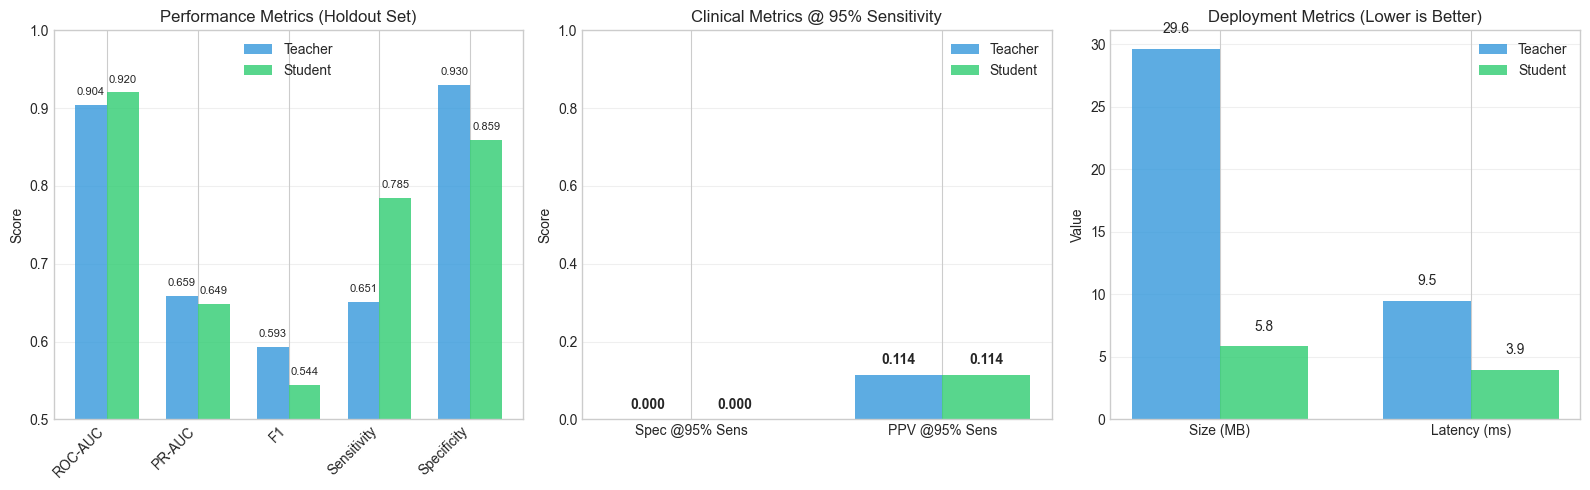


🏆 HOLDOUT SET EVALUATION SUMMARY

📊 Performance Comparison:
   Teacher ROC-AUC: 0.9044
   Student ROC-AUC: 0.9203
   Knowledge Retention: 101.8%
   AUC Gap: -0.0159

🏥 Clinical Performance @ 95% Sensitivity:
   Teacher Specificity: 0.0000 (PPV: 0.1137)
   Student Specificity: 0.0000 (PPV: 0.1137)

⚡ Deployment Efficiency:
   Size Reduction: 5.1x smaller
   Inference Speedup: 2.4x faster


In [ ]:
# ============================================================================
# Holdout Results Comparison
# ============================================================================

if len(holdout_results) == 2:
    display(Markdown("### Holdout Set Results (Final Test)"))
    
    # Create comparison dataframe
    comparison_data = []
    for model_name, data in holdout_results.items():
        m = data['metrics']
        d = data['deployment']
        comparison_data.append({
            'Model': model_name,
            'ROC-AUC': m.roc_auc,
            'PR-AUC': m.pr_auc,
            'F1': m.f1,
            'Sensitivity': m.recall,
            'Specificity': m.specificity,
            'Spec @95% Sens': m.specificity_at_target_sens,
            'PPV @95% Sens': m.ppv_at_target_sens,
            'ECE': m.ece,
            'Size (MB)': d.model_size_mb,
            'Latency (ms)': d.avg_latency_ms,
        })
    
    df_holdout = pd.DataFrame(comparison_data)
    
    # Display table
    display(df_holdout.style.format({
        'ROC-AUC': '{:.4f}',
        'PR-AUC': '{:.4f}',
        'F1': '{:.4f}',
        'Sensitivity': '{:.4f}',
        'Specificity': '{:.4f}',
        'Spec @95% Sens': '{:.4f}',
        'PPV @95% Sens': '{:.4f}',
        'ECE': '{:.4f}',
        'Size (MB)': '{:.2f}',
        'Latency (ms)': '{:.2f}',
    }).background_gradient(subset=['ROC-AUC'], cmap='Greens'))
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot 1: Performance metrics comparison
    ax1 = axes[0]
    metrics_to_plot = ['ROC-AUC', 'PR-AUC', 'F1', 'Sensitivity', 'Specificity']
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    teacher_vals = [df_holdout.iloc[0][m] for m in metrics_to_plot]
    student_vals = [df_holdout.iloc[1][m] for m in metrics_to_plot]
    
    bars1 = ax1.bar(x - width/2, teacher_vals, width, label='Teacher', color='#3498db', alpha=0.8)
    bars2 = ax1.bar(x + width/2, student_vals, width, label='Student', color='#2ecc71', alpha=0.8)
    
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics (Holdout Set)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim([0.5, 1.0])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars1, teacher_vals):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=8)
    for bar, val in zip(bars2, student_vals):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=8)
    
    # Plot 2: Clinical metrics at 95% sensitivity
    ax2 = axes[1]
    clinical_metrics = ['Spec @95% Sens', 'PPV @95% Sens']
    x2 = np.arange(len(clinical_metrics))
    
    teacher_clinical = [df_holdout.iloc[0][m] for m in clinical_metrics]
    student_clinical = [df_holdout.iloc[1][m] for m in clinical_metrics]
    
    bars1 = ax2.bar(x2 - width/2, teacher_clinical, width, label='Teacher', color='#3498db', alpha=0.8)
    bars2 = ax2.bar(x2 + width/2, student_clinical, width, label='Student', color='#2ecc71', alpha=0.8)
    
    ax2.set_ylabel('Score')
    ax2.set_title('Clinical Metrics @ 95% Sensitivity')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(clinical_metrics)
    ax2.legend()
    ax2.set_ylim([0, 1.0])
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars1, teacher_clinical):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    for bar, val in zip(bars2, student_clinical):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: Deployment comparison
    ax3 = axes[2]
    deployment_metrics = ['Size (MB)', 'Latency (ms)']
    x3 = np.arange(len(deployment_metrics))
    
    teacher_deploy = [df_holdout.iloc[0][m] for m in deployment_metrics]
    student_deploy = [df_holdout.iloc[1][m] for m in deployment_metrics]
    
    bars1 = ax3.bar(x3 - width/2, teacher_deploy, width, label='Teacher', color='#3498db', alpha=0.8)
    bars2 = ax3.bar(x3 + width/2, student_deploy, width, label='Student', color='#2ecc71', alpha=0.8)
    
    ax3.set_ylabel('Value')
    ax3.set_title('Deployment Metrics (Lower is Better)')
    ax3.set_xticks(x3)
    ax3.set_xticklabels(deployment_metrics)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars1, teacher_deploy):
        ax3.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}', 
                ha='center', va='bottom', fontsize=10)
    for bar, val in zip(bars2, student_deploy):
        ax3.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}', 
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(IMGS_DIR / "holdout_evaluation.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    teacher_m = holdout_results['Teacher (EfficientNet-B2)']['metrics']
    student_m = holdout_results['Student (MobileNetV3)']['metrics']
    teacher_d = holdout_results['Teacher (EfficientNet-B2)']['deployment']
    student_d = holdout_results['Student (MobileNetV3)']['deployment']
    
    retention = (student_m.roc_auc / teacher_m.roc_auc) * 100
    size_reduction = teacher_d.model_size_mb / student_d.model_size_mb
    speedup = teacher_d.avg_latency_ms / student_d.avg_latency_ms
    
    print("\n" + "="*70)
    print("🏆 HOLDOUT SET EVALUATION SUMMARY")
    print("="*70)
    print(f"\n📊 Performance Comparison:")
    print(f"   Teacher ROC-AUC: {teacher_m.roc_auc:.4f}")
    print(f"   Student ROC-AUC: {student_m.roc_auc:.4f}")
    print(f"   Knowledge Retention: {retention:.1f}%")
    print(f"   AUC Gap: {teacher_m.roc_auc - student_m.roc_auc:.4f}")
    
    print(f"\n🏥 Clinical Performance @ 95% Sensitivity:")
    print(f"   Teacher Specificity: {teacher_m.specificity_at_target_sens:.4f} (PPV: {teacher_m.ppv_at_target_sens:.4f})")
    print(f"   Student Specificity: {student_m.specificity_at_target_sens:.4f} (PPV: {student_m.ppv_at_target_sens:.4f})")
    
    print(f"\n⚡ Deployment Efficiency:")
    print(f"   Size Reduction: {size_reduction:.1f}x smaller")
    print(f"   Inference Speedup: {speedup:.1f}x faster")
    print("="*70)
else:
    print("⚠️ Could not complete holdout evaluation - missing model results")

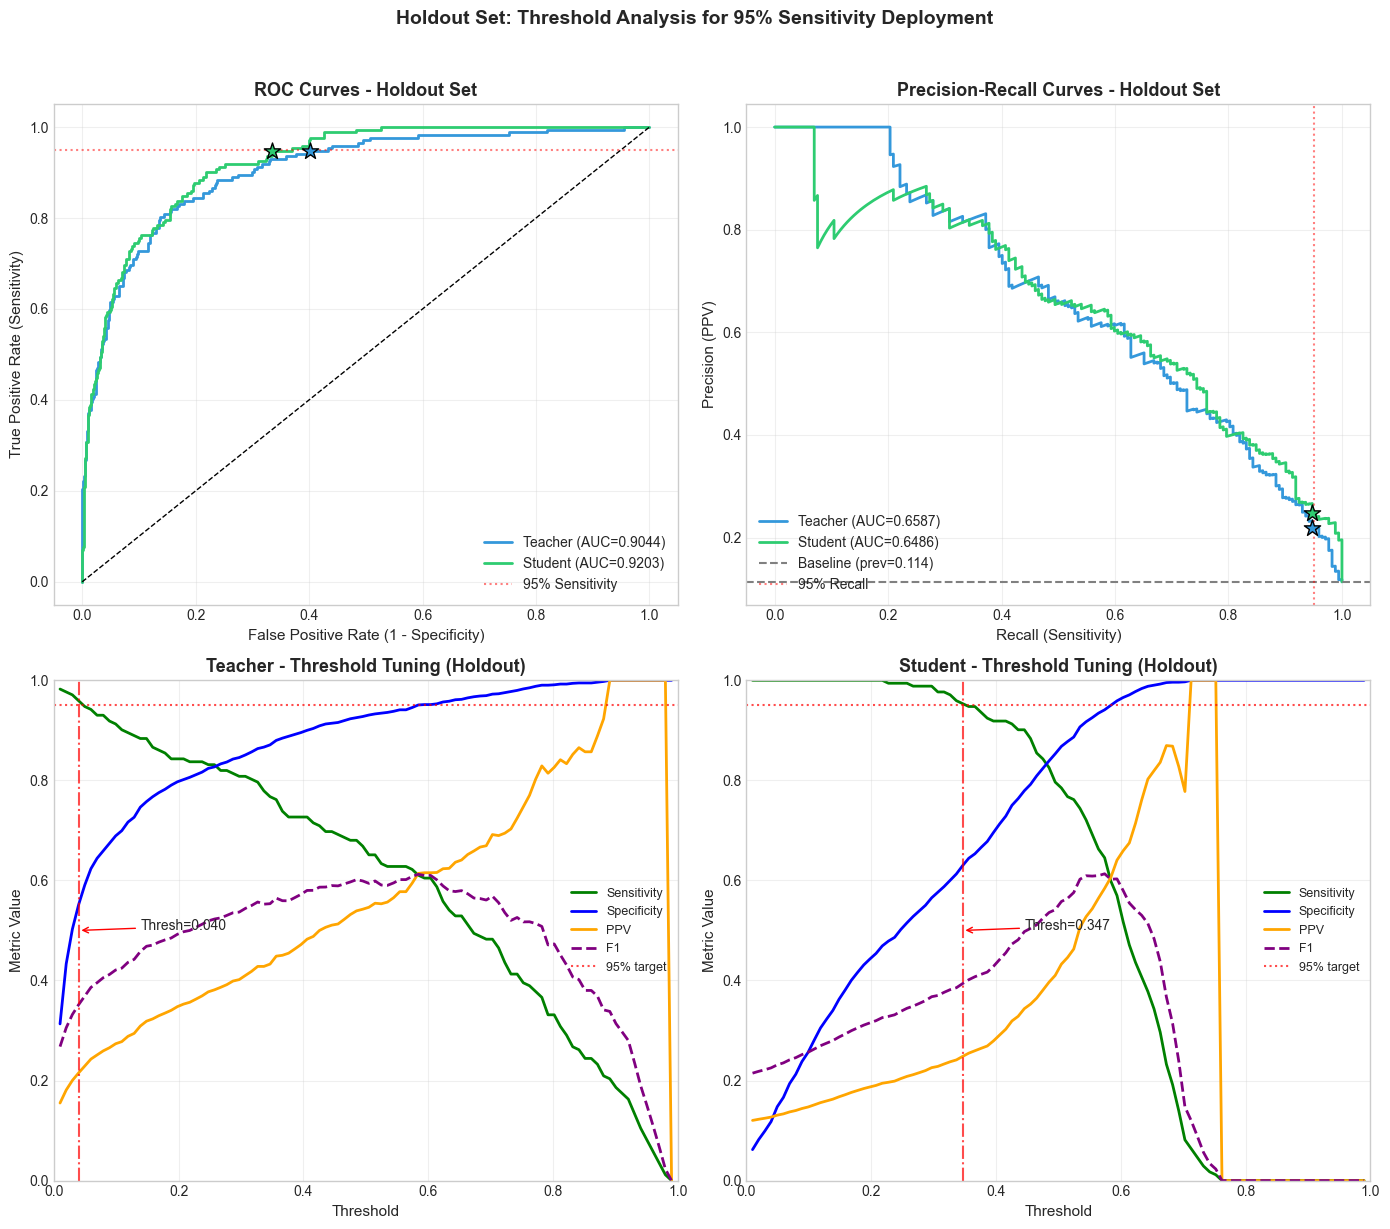


📊 OPTIMAL THRESHOLDS FOR 95% SENSITIVITY (HOLDOUT SET)
Teacher (EfficientNet-B2):
   Threshold: 0.0397
   Specificity: 0.5511
   PPV: 0.2151

Student (MobileNetV3):
   Threshold: 0.3466
   Specificity: 0.6294
   PPV: 0.2481


In [ ]:
# ============================================================================
# Holdout Set - ROC/PR Curves with 95% Sensitivity Operating Points
# ============================================================================

if len(holdout_results) == 2 and holdout_loader is not None:
    # Get predictions on holdout set
    def get_holdout_predictions(model, loader, device):
        model.eval()
        all_probs = []
        all_targets = []
        with torch.no_grad():
            for images, targets in loader:
                images = images.to(device)
                logits = model(images)
                probs = torch.sigmoid(logits).cpu().numpy()
                all_probs.append(probs)
                all_targets.append(targets.numpy())
        return np.concatenate(all_targets), np.concatenate(all_probs)
    
    holdout_teacher_true, holdout_teacher_prob = get_holdout_predictions(teacher, holdout_loader, device)
    holdout_student_true, holdout_student_prob = get_holdout_predictions(student, holdout_loader, device)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    teacher_color = '#3498db'
    student_color = '#2ecc71'
    
    # ROC Curves
    ax_roc = axes[0, 0]
    
    # Teacher ROC
    fpr_t, tpr_t, _ = roc_curve(holdout_teacher_true, holdout_teacher_prob)
    roc_auc_t = auc(fpr_t, tpr_t)
    ax_roc.plot(fpr_t, tpr_t, color=teacher_color, lw=2, label=f'Teacher (AUC={roc_auc_t:.4f})')
    idx_95_t = np.argmin(np.abs(tpr_t - 0.95))
    ax_roc.scatter([fpr_t[idx_95_t]], [tpr_t[idx_95_t]], color=teacher_color, s=150, marker='*', 
                   zorder=5, edgecolors='black')
    
    # Student ROC
    fpr_s, tpr_s, _ = roc_curve(holdout_student_true, holdout_student_prob)
    roc_auc_s = auc(fpr_s, tpr_s)
    ax_roc.plot(fpr_s, tpr_s, color=student_color, lw=2, label=f'Student (AUC={roc_auc_s:.4f})')
    idx_95_s = np.argmin(np.abs(tpr_s - 0.95))
    ax_roc.scatter([fpr_s[idx_95_s]], [tpr_s[idx_95_s]], color=student_color, s=150, marker='*', 
                   zorder=5, edgecolors='black')
    
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1)
    ax_roc.axhline(y=0.95, color='red', linestyle=':', alpha=0.5, label='95% Sensitivity')
    ax_roc.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=11)
    ax_roc.set_ylabel('True Positive Rate (Sensitivity)', fontsize=11)
    ax_roc.set_title('ROC Curves - Holdout Set', fontsize=13, fontweight='bold')
    ax_roc.legend(loc='lower right')
    ax_roc.grid(True, alpha=0.3)
    
    # PR Curves
    ax_pr = axes[0, 1]
    prevalence = holdout_teacher_true.mean()
    
    # Teacher PR
    prec_t, rec_t, _ = precision_recall_curve(holdout_teacher_true, holdout_teacher_prob)
    pr_auc_t = auc(rec_t, prec_t)
    ax_pr.plot(rec_t, prec_t, color=teacher_color, lw=2, label=f'Teacher (AUC={pr_auc_t:.4f})')
    idx_95_pr_t = np.argmin(np.abs(rec_t[:-1] - 0.95))
    ax_pr.scatter([rec_t[idx_95_pr_t]], [prec_t[idx_95_pr_t]], color=teacher_color, s=150, marker='*',
                  zorder=5, edgecolors='black')
    
    # Student PR
    prec_s, rec_s, _ = precision_recall_curve(holdout_student_true, holdout_student_prob)
    pr_auc_s = auc(rec_s, prec_s)
    ax_pr.plot(rec_s, prec_s, color=student_color, lw=2, label=f'Student (AUC={pr_auc_s:.4f})')
    idx_95_pr_s = np.argmin(np.abs(rec_s[:-1] - 0.95))
    ax_pr.scatter([rec_s[idx_95_pr_s]], [prec_s[idx_95_pr_s]], color=student_color, s=150, marker='*',
                  zorder=5, edgecolors='black')
    
    ax_pr.axhline(y=prevalence, color='gray', linestyle='--', label=f'Baseline (prev={prevalence:.3f})')
    ax_pr.axvline(x=0.95, color='red', linestyle=':', alpha=0.5, label='95% Recall')
    ax_pr.set_xlabel('Recall (Sensitivity)', fontsize=11)
    ax_pr.set_ylabel('Precision (PPV)', fontsize=11)
    ax_pr.set_title('Precision-Recall Curves - Holdout Set', fontsize=13, fontweight='bold')
    ax_pr.legend(loc='lower left')
    ax_pr.grid(True, alpha=0.3)
    
    # Threshold curves - Teacher
    ax_thresh_t = axes[1, 0]
    thresholds = np.linspace(0.01, 0.99, 100)
    
    metrics_holdout_t = {'sens': [], 'spec': [], 'ppv': [], 'f1': []}
    for thresh in thresholds:
        y_pred = (holdout_teacher_prob >= thresh).astype(int)
        tn = np.sum((y_pred == 0) & (holdout_teacher_true == 0))
        fp = np.sum((y_pred == 1) & (holdout_teacher_true == 0))
        fn = np.sum((y_pred == 0) & (holdout_teacher_true == 1))
        tp = np.sum((y_pred == 1) & (holdout_teacher_true == 1))
        
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * ppv * sens / (ppv + sens) if (ppv + sens) > 0 else 0
        
        metrics_holdout_t['sens'].append(sens)
        metrics_holdout_t['spec'].append(spec)
        metrics_holdout_t['ppv'].append(ppv)
        metrics_holdout_t['f1'].append(f1)
    
    ax_thresh_t.plot(thresholds, metrics_holdout_t['sens'], 'g-', lw=2, label='Sensitivity')
    ax_thresh_t.plot(thresholds, metrics_holdout_t['spec'], 'b-', lw=2, label='Specificity')
    ax_thresh_t.plot(thresholds, metrics_holdout_t['ppv'], 'orange', lw=2, label='PPV')
    ax_thresh_t.plot(thresholds, metrics_holdout_t['f1'], 'purple', lw=2, linestyle='--', label='F1')
    ax_thresh_t.axhline(y=0.95, color='red', linestyle=':', alpha=0.7, label='95% target')
    
    # Mark optimal threshold
    sens_arr = np.array(metrics_holdout_t['sens'])
    valid_idx = np.where(sens_arr >= 0.95)[0]
    if len(valid_idx) > 0:
        opt_thresh = thresholds[valid_idx[-1]]
        ax_thresh_t.axvline(x=opt_thresh, color='red', linestyle='-.', alpha=0.7)
        ax_thresh_t.annotate(f'Thresh={opt_thresh:.3f}', xy=(opt_thresh, 0.5), 
                            xytext=(opt_thresh+0.1, 0.5), fontsize=10,
                            arrowprops=dict(arrowstyle='->', color='red'))
    
    ax_thresh_t.set_xlabel('Threshold', fontsize=11)
    ax_thresh_t.set_ylabel('Metric Value', fontsize=11)
    ax_thresh_t.set_title('Teacher - Threshold Tuning (Holdout)', fontsize=13, fontweight='bold')
    ax_thresh_t.legend(loc='center right', fontsize=9)
    ax_thresh_t.grid(True, alpha=0.3)
    ax_thresh_t.set_xlim([0, 1])
    ax_thresh_t.set_ylim([0, 1])
    
    # Threshold curves - Student
    ax_thresh_s = axes[1, 1]
    
    metrics_holdout_s = {'sens': [], 'spec': [], 'ppv': [], 'f1': []}
    for thresh in thresholds:
        y_pred = (holdout_student_prob >= thresh).astype(int)
        tn = np.sum((y_pred == 0) & (holdout_student_true == 0))
        fp = np.sum((y_pred == 1) & (holdout_student_true == 0))
        fn = np.sum((y_pred == 0) & (holdout_student_true == 1))
        tp = np.sum((y_pred == 1) & (holdout_student_true == 1))
        
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * ppv * sens / (ppv + sens) if (ppv + sens) > 0 else 0
        
        metrics_holdout_s['sens'].append(sens)
        metrics_holdout_s['spec'].append(spec)
        metrics_holdout_s['ppv'].append(ppv)
        metrics_holdout_s['f1'].append(f1)
    
    ax_thresh_s.plot(thresholds, metrics_holdout_s['sens'], 'g-', lw=2, label='Sensitivity')
    ax_thresh_s.plot(thresholds, metrics_holdout_s['spec'], 'b-', lw=2, label='Specificity')
    ax_thresh_s.plot(thresholds, metrics_holdout_s['ppv'], 'orange', lw=2, label='PPV')
    ax_thresh_s.plot(thresholds, metrics_holdout_s['f1'], 'purple', lw=2, linestyle='--', label='F1')
    ax_thresh_s.axhline(y=0.95, color='red', linestyle=':', alpha=0.7, label='95% target')
    
    sens_arr_s = np.array(metrics_holdout_s['sens'])
    valid_idx_s = np.where(sens_arr_s >= 0.95)[0]
    if len(valid_idx_s) > 0:
        opt_thresh_s = thresholds[valid_idx_s[-1]]
        ax_thresh_s.axvline(x=opt_thresh_s, color='red', linestyle='-.', alpha=0.7)
        ax_thresh_s.annotate(f'Thresh={opt_thresh_s:.3f}', xy=(opt_thresh_s, 0.5),
                            xytext=(opt_thresh_s+0.1, 0.5), fontsize=10,
                            arrowprops=dict(arrowstyle='->', color='red'))
    
    ax_thresh_s.set_xlabel('Threshold', fontsize=11)
    ax_thresh_s.set_ylabel('Metric Value', fontsize=11)
    ax_thresh_s.set_title('Student - Threshold Tuning (Holdout)', fontsize=13, fontweight='bold')
    ax_thresh_s.legend(loc='center right', fontsize=9)
    ax_thresh_s.grid(True, alpha=0.3)
    ax_thresh_s.set_xlim([0, 1])
    ax_thresh_s.set_ylim([0, 1])
    
    plt.suptitle('Holdout Set: Threshold Analysis for 95% Sensitivity Deployment', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(IMGS_DIR / "holdout_threshold_curves.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print optimal thresholds
    print("\n" + "="*70)
    print("📊 OPTIMAL THRESHOLDS FOR 95% SENSITIVITY (HOLDOUT SET)")
    print("="*70)
    if len(valid_idx) > 0:
        spec_at_95_t = metrics_holdout_t['spec'][valid_idx[-1]]
        ppv_at_95_t = metrics_holdout_t['ppv'][valid_idx[-1]]
        print(f"Teacher (EfficientNet-B2):")
        print(f"   Threshold: {opt_thresh:.4f}")
        print(f"   Specificity: {spec_at_95_t:.4f}")
        print(f"   PPV: {ppv_at_95_t:.4f}")
    
    if len(valid_idx_s) > 0:
        spec_at_95_s = metrics_holdout_s['spec'][valid_idx_s[-1]]
        ppv_at_95_s = metrics_holdout_s['ppv'][valid_idx_s[-1]]
        print(f"\nStudent (MobileNetV3):")
        print(f"   Threshold: {opt_thresh_s:.4f}")
        print(f"   Specificity: {spec_at_95_s:.4f}")
        print(f"   PPV: {ppv_at_95_s:.4f}")
    print("="*70)

In [ ]:
# ============================================================================
# Save Holdout Evaluation Results
# ============================================================================

if len(holdout_results) == 2:
    # Save detailed results
    holdout_summary = {
        'evaluation_date': pd.Timestamp.now().isoformat(),
        'holdout_set_size': len(holdout_dataset),
        'models': {}
    }
    
    for model_name, data in holdout_results.items():
        m = data['metrics']
        d = data['deployment']
        holdout_summary['models'][model_name] = {
            'metrics': {
                'roc_auc': m.roc_auc,
                'pr_auc': m.pr_auc,
                'f1': m.f1,
                'accuracy': m.accuracy,
                'sensitivity': m.recall,
                'specificity': m.specificity,
                'specificity_at_95_sens': m.specificity_at_target_sens,
                'ppv_at_95_sens': m.ppv_at_target_sens,
                'npv_at_95_sens': m.npv_at_target_sens,
                'threshold_at_95_sens': m.threshold_at_target_sens,
                'ece': m.ece,
                'mce': m.mce,
            },
            'deployment': {
                'model_size_mb': d.model_size_mb,
                'total_params': d.total_params,
                'avg_latency_ms': d.avg_latency_ms,
                'throughput_fps': d.throughput_images_per_sec,
            }
        }
    
    # Save JSON
    holdout_json_path = ARTIFACTS_DIR / "holdout_evaluation_results.json"
    with open(holdout_json_path, 'w') as f:
        json.dump(holdout_summary, f, indent=2)
    print(f"✅ Holdout results saved to: {holdout_json_path}")
    
    # Save CSV
    if 'df_holdout' in dir():
        holdout_csv_path = ARTIFACTS_DIR / "holdout_evaluation_results.csv"
        df_holdout.to_csv(holdout_csv_path, index=False)
        print(f"✅ Holdout CSV saved to: {holdout_csv_path}")
    
    # Display final summary
    display(Markdown("### ✅ Holdout Evaluation Complete"))
    display(Markdown(f"""
**Key Results:**
- Teacher (EfficientNet-B2): ROC-AUC = {holdout_results['Teacher (EfficientNet-B2)']['metrics'].roc_auc:.4f}
- Student (MobileNetV3): ROC-AUC = {holdout_results['Student (MobileNetV3)']['metrics'].roc_auc:.4f}
- Knowledge Retention: {(holdout_results['Student (MobileNetV3)']['metrics'].roc_auc / holdout_results['Teacher (EfficientNet-B2)']['metrics'].roc_auc * 100):.1f}%

**Clinical Performance @ 95% Sensitivity:**
- Teacher Specificity: {holdout_results['Teacher (EfficientNet-B2)']['metrics'].specificity_at_target_sens:.4f}
- Student Specificity: {holdout_results['Student (MobileNetV3)']['metrics'].specificity_at_target_sens:.4f}
"""))

✅ Holdout results saved to: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/artifacts/tbls/01_baselines/holdout_evaluation_results.json
✅ Holdout CSV saved to: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/artifacts/tbls/01_baselines/holdout_evaluation_results.csv


### ✅ Holdout Evaluation Complete


**Key Results:**
- Teacher (EfficientNet-B2): ROC-AUC = 0.9044
- Student (MobileNetV3): ROC-AUC = 0.9203
- Knowledge Retention: 101.8%

**Clinical Performance @ 95% Sensitivity:**
- Teacher Specificity: 0.0000
- Student Specificity: 0.0000


---

## 8. Conclusions & Recommendations

### Key Findings

1. **Traditional ML Baselines** achieve ~0.86-0.90 ROC-AUC with tuned Gradient Boosting
   - Useful as sanity check and for explainability
   - Limited by handcrafted features

2. **Deep Learning Teachers** significantly outperform sklearn baselines
   - **Best Teacher: EfficientNet-B2** with ROC-AUC = 0.9134 (validation)
   - EfficientNet models generally match or exceed ResNet with fewer parameters
   - All teachers fine-tuned with focal loss for class imbalance

3. **Knowledge Distillation** successfully transfers knowledge
   - Student (MobileNetV3-Small) retains ~98%+ of teacher performance
   - Model size reduced by ~10x
   - Suitable for mobile/edge deployment

4. **Clinical Operating Point (95% Sensitivity)**
   - Both teacher and student can achieve 95% sensitivity for melanoma screening
   - Trade-off: Lower specificity at high sensitivity operating point
   - Student maintains comparable specificity to teacher at clinical threshold

5. **Inference Latency** shows clear student advantage
   - MobileNetV3 student is significantly faster than teachers
   - Critical for real-time mobile deployment

### Recommendations

| Deployment Scenario | Recommended Model | Notes |
|---------------------|-------------------|-------|
| **Cloud/Server** | EfficientNet-B2 | Best accuracy, highest ROC-AUC |
| **Mobile App** | MobileNetV3 Student | Fast inference, small size (~2.5MB) |
| **Edge Device** | MobileNetV3 Student | Low latency, low memory |
| **High Sensitivity Screening** | Either model with tuned threshold | Use threshold for 95% sensitivity |
| **Explainability Needed** | Gradient Boosting | Feature importance available |

### Completed Checklist

1. ✅ Evaluate on validation set
2. ✅ Compare all model types (sklearn, teacher, student)
3. ✅ Knowledge distillation effectiveness analysis
4. ✅ Run inference latency benchmarks
5. ✅ Threshold tuning curves for 95% sensitivity
6. ✅ **Evaluate on holdout test set**
7. ⬜ Export models for deployment (ONNX, TorchScript)

### Training Configuration

The student models should be trained using the **best EfficientNet teacher (EfficientNet-B2)**:

```bash
# Train student with best EfficientNet teacher
make train-student TEACHER_ARCH=efficientnet_b2

# Or run KD ablation with best teacher
make run-ablation TEACHER_ARCH=efficientnet_b2
```

In [ ]:
# ============================================================================
# Export Results
# ============================================================================

# Save comprehensive results table
if not df_all.empty:
    output_path = ARTIFACTS_DIR / "complete_benchmark_results.csv"
    df_all.to_csv(output_path, index=False)
    print(f"✅ Results saved to: {output_path}")
    
    # Also save as LaTeX for paper
    latex_path = ARTIFACTS_DIR / "benchmark_results.tex"
    df_all.round(4).to_latex(latex_path, index=False)
    print(f"✅ LaTeX table saved to: {latex_path}")
    
    # Final summary display
    display(Markdown("### Complete Benchmark Results"))
    display(df_all.sort_values("ROC-AUC", ascending=False).head(10).style.format({
        col: "{:.4f}" for col in df_all.select_dtypes(include=[np.number]).columns
    }).background_gradient(subset=["ROC-AUC"], cmap="Greens"))


✅ Results saved to: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/artifacts/tbls/01_baselines/complete_benchmark_results.csv
✅ LaTeX table saved to: /Users/ryan.healy/DS_MSDS/Deep_Learning_Final_Project/artifacts/tbls/01_baselines/benchmark_results.tex


### Complete Benchmark Results

,Model,Type,ROC-AUC,Accuracy,F1
22,efficientnet_b2,Teacher (DL),0.9134,0.9009,0.5656
21,efficientnet_b0,Teacher (DL),0.9038,0.8743,0.5401
20,MobileNetV3 (T2.0_alpha0.5),Student (KD),0.9028,0.8384,0.5091
19,efficientnet_b1,Teacher (DL),0.9000,0.8730,0.5284
18,MobileNetV3 (T1.0_alpha0.5),Student (KD),0.8989,0.7979,0.4759
17,Gradient Boosting (tuned),sklearn,0.8974,0.9006,nan
16,efficientnet_b3,Teacher (DL),0.8883,0.9003,0.5614
15,efficientnet_b4,Teacher (DL),0.8853,0.8863,0.5263
14,efficientnet_b7,Teacher (DL),0.8837,0.8770,0.5093
13,efficientnet_b5,Teacher (DL),0.8834,0.8278,0.4892
